# MNIST callbacks

This example assumes you've read `callbacks/basic.ipynb`, and covers:

  - Creating advanced custom callbacks
  - Using and modifying builtin callbacks
  - Visualization, data gathering, and random seed setting callbacks

In [1]:
import os
import sys
from pathlib import Path
os.environ['TF_KERAS'] = '1'
os.environ['SCALEFIG'] = '.7'  # scale all drawn plots by 0.7
sys.path.insert(0, str(Path(Path.cwd()).parents[1]))
sys.path.insert(0, os.path.join(Path(Path.cwd()).parents[2], "see-rnn"))

import os
import sys
import deeptrain
deeptrain.append_examples_dir_to_sys_path()
logger_savedir = os.path.join(sys.path[0], "outputs", "logger")

from utils import make_classifier, init_session, img_labels_paths
from utils import Adam
from utils import CL_CONFIGS as C
from see_rnn import features_2D
import numpy as np

from deeptrain.callbacks import TraingenCallback, TraingenLogger
from deeptrain.callbacks import RandomSeedSetter
from deeptrain.callbacks import make_layer_hists_cb

In [2]:
%config InlineBackend.figure_format = 'retina'  # greatly improve display quality

### Data Logger
  - Gathers data throughout training: weights, outputs, and gradients of model layers. 
  - We inherit the base class and override methods where we wish actions to occur: on save, load, and end of train epoch.

In [3]:
class TraingenLoggerCB(TraingenLogger):
    def __init__(self, savedir, configs, **kwargs):
        super().__init__(savedir, configs, **kwargs)

    def on_save(self, stage=None):
        self.save(_id=self.tg.epoch)  # `tg` will be set inside TrainGenerator

    def on_load(self, stage=None):
        self.clear()
        self.load()

    def on_train_epoch_end(self, stage=None):
        self.log()

log_configs = {
    'weights': ['conv2d'],
    'outputs': 'conv2d',
    'gradients': ('conv2d',),
    'outputs-kw': dict(learning_phase=0),
    'gradients-kw': dict(learning_phase=0),
}
tg_logger = TraingenLoggerCB(logger_savedir, log_configs)

### Outputs visuals
 - Plots weights of the second Conv2D layer at end of each epoch.
 - Weights are reshaped such that subplot 'boxes' are output channels.
 - Each box plots flattened spatial dims vertically and input features horizontally.

In [4]:
class ConvWeightsHeatmap(TraingenCallback):
    def on_val_end(self, stage=None):
        if stage == ('val_end', 'train:epoch'):
            self.viz()

    def viz(self):
        w = self.tg.model.layers[2].get_weights()[0]
        w = w.reshape(-1, *w.shape[2:])  # flatten along spatial dims
        w = w.transpose(2, 0, 1)  # (out_features, spatial dims x in_features)

        if not hasattr(self, 'init_norm'):
            # maintain same norm throughout plots for consistency
            mx = np.max(np.abs(w))
            self.init_norm = (-mx, mx)

        features_2D(w, tight=True, w=.4, h=.4, title=None, show_xy_ticks=0,
                    norm=self.init_norm)

cwh = ConvWeightsHeatmap()

Callbacks can also be configured as str-function dict pairs, where str is name of a callback "stage" 
(see `tg._cb_alias after tg.train()`).

In [5]:
grad_hists = {'train:epoch': [make_layer_hists_cb(mode='gradients:outputs'),
                              make_layer_hists_cb(mode='gradients:weights')]}
weight_hists = {('val_end', 'train:epoch'): make_layer_hists_cb(mode='weights')}

configs = {'title': dict(fontsize=13), 'plot': dict(annot_kw=None)}
layer_outputs_hists = {'val_end': 
                       make_layer_hists_cb(mode='outputs', configs=configs)}

### Random seed setter
Sets new random seeds (`random`, `numpy`, TF-graph, TF-global) every epoch, incrementing by 1 from start value (default 0)

In [6]:
seed_setter = RandomSeedSetter(freq={'train:epoch': 2})

### Init & train

In [7]:
C['traingen']['callbacks'] = [seed_setter, tg_logger, cwh, grad_hists,
                              weight_hists, layer_outputs_hists]
C['traingen']['epochs'] = 4
C['traingen']['iter_verbosity'] = 0
C['datagen']['labels_path']     = img_labels_paths[0]
C['val_datagen']['labels_path'] = img_labels_paths[1]
C['model']['optimizer'] = Adam(1e-2)
tg = init_session(C, make_classifier)

Discovered 48 files with matching format
Discovered dataset with matching format
48 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Discovered 36 files with matching format
Discovered dataset with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Preloading superbatch ... Discovered 48 files with matching format
................................................ finished, w/ 6144 total samples
Train initial data prepared
Preloading superbatch ... Discovered 36 files with matching format
.................................... finished, w/ 4608 total samples
Val initial data prepared
Logging ON; directory (new): C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logs\M1__model-Adam__min999.000



Data set_nums shuffled


_____________________
 EPOCH 1 -- COMPLETE 



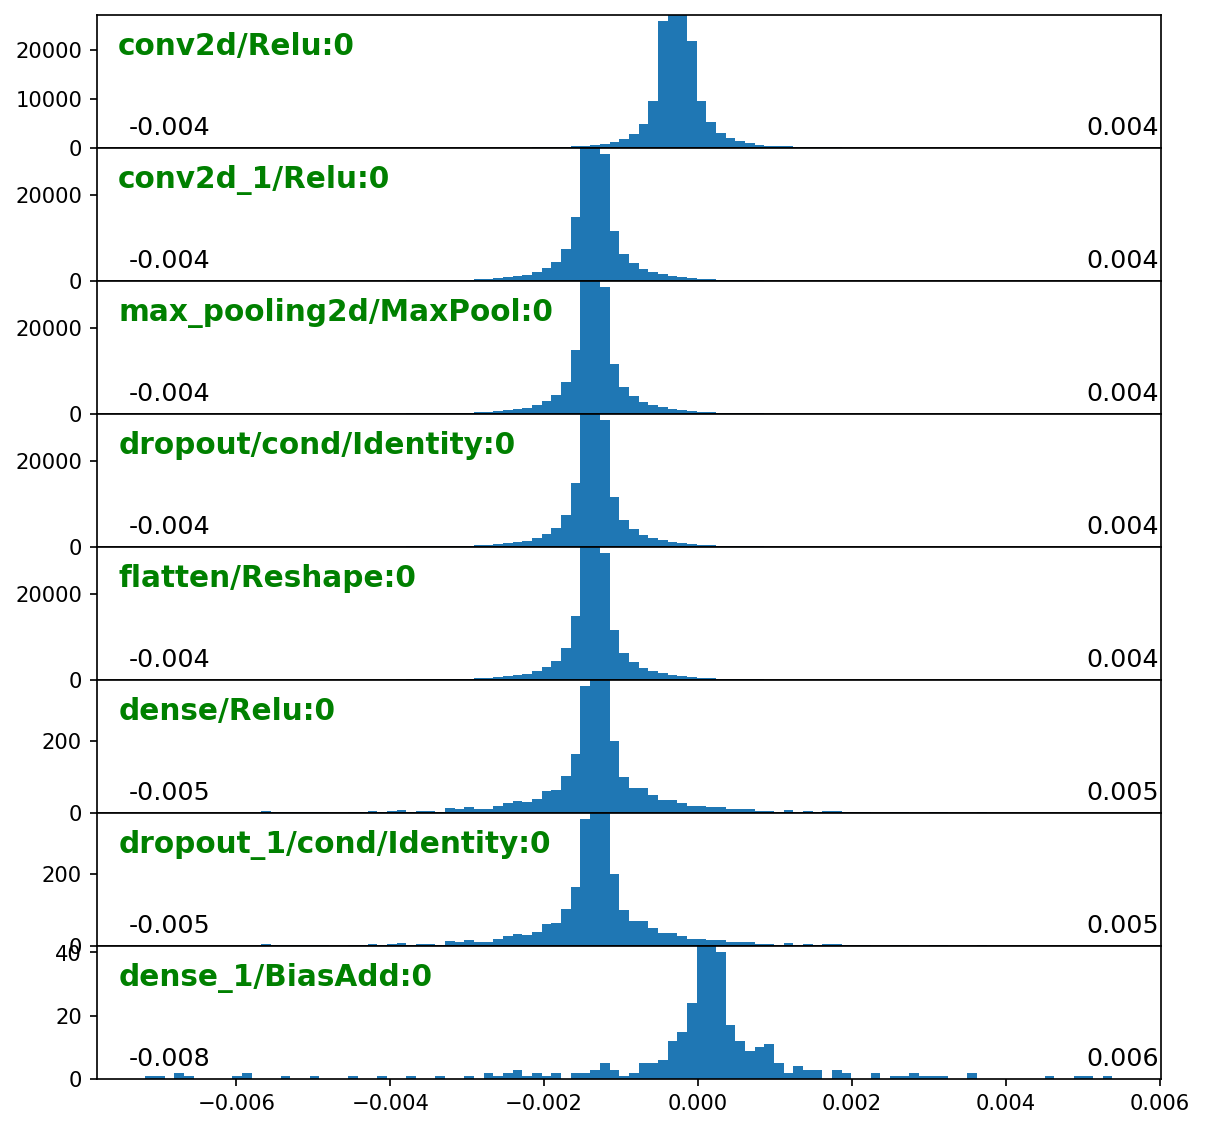

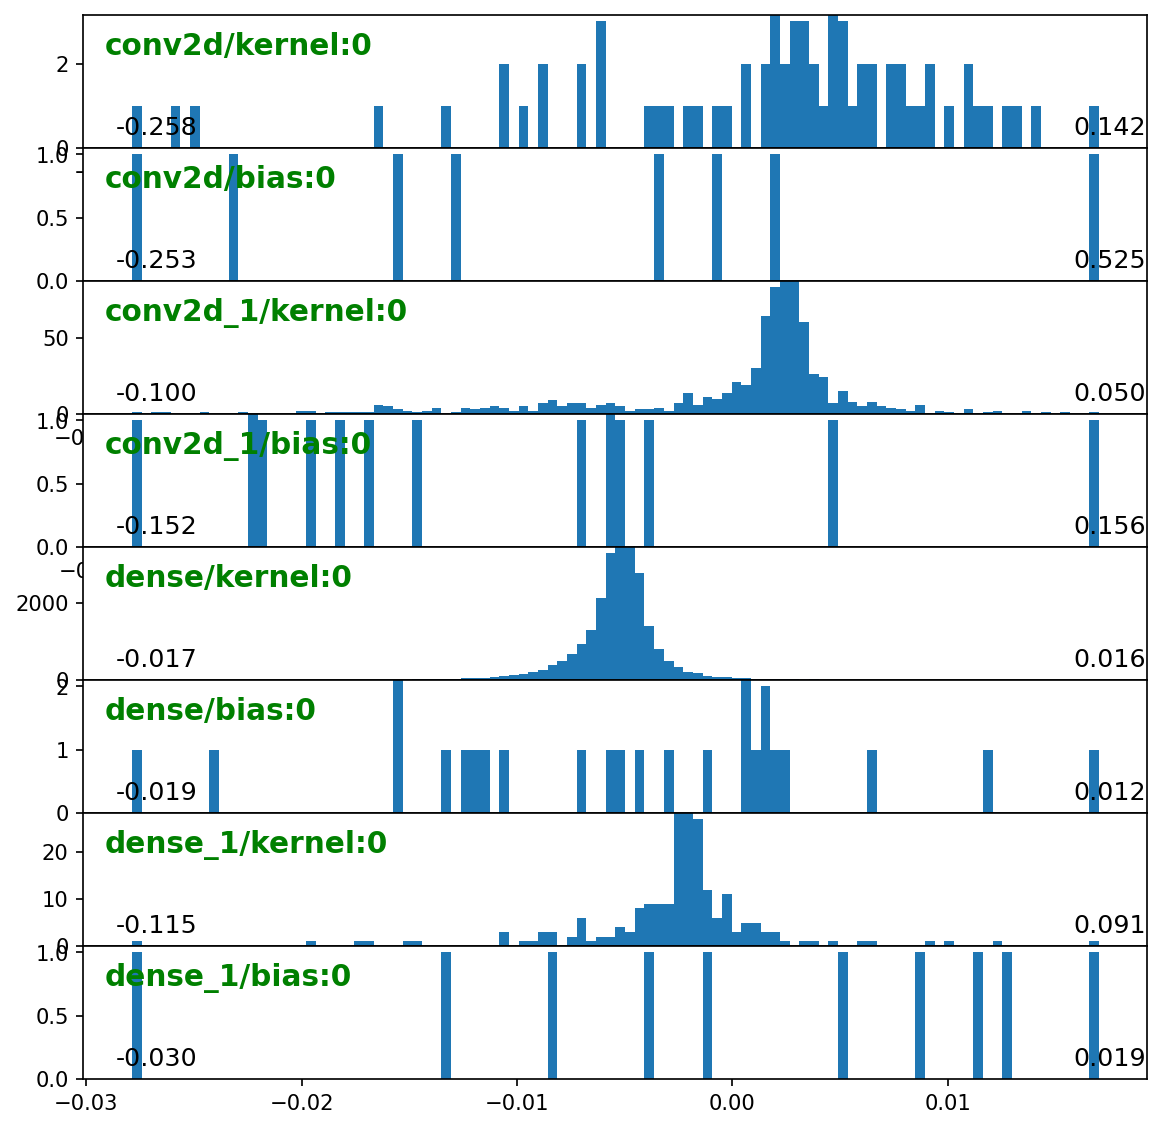



Validating...
TraingenLogger data saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logger\datalog_1.h5
TrainGenerator state saved
Model report generated and saved
Best model saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\models\M1__model-Adam__min.238
TraingenLogger data saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logger\datalog_1.h5
TrainGenerator state saved
Model report generated and saved


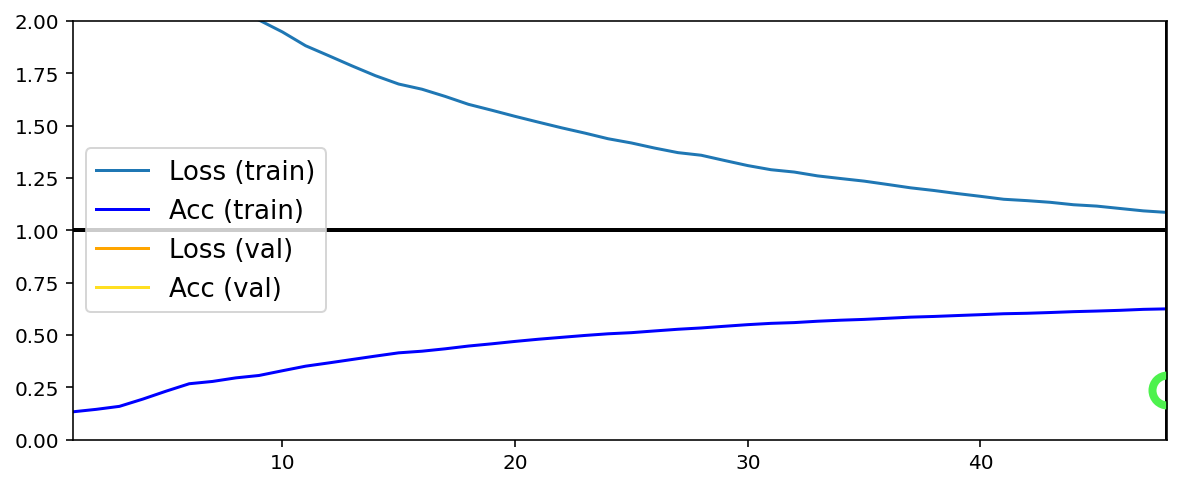

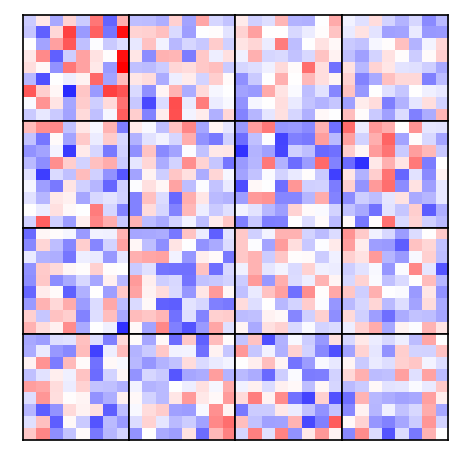

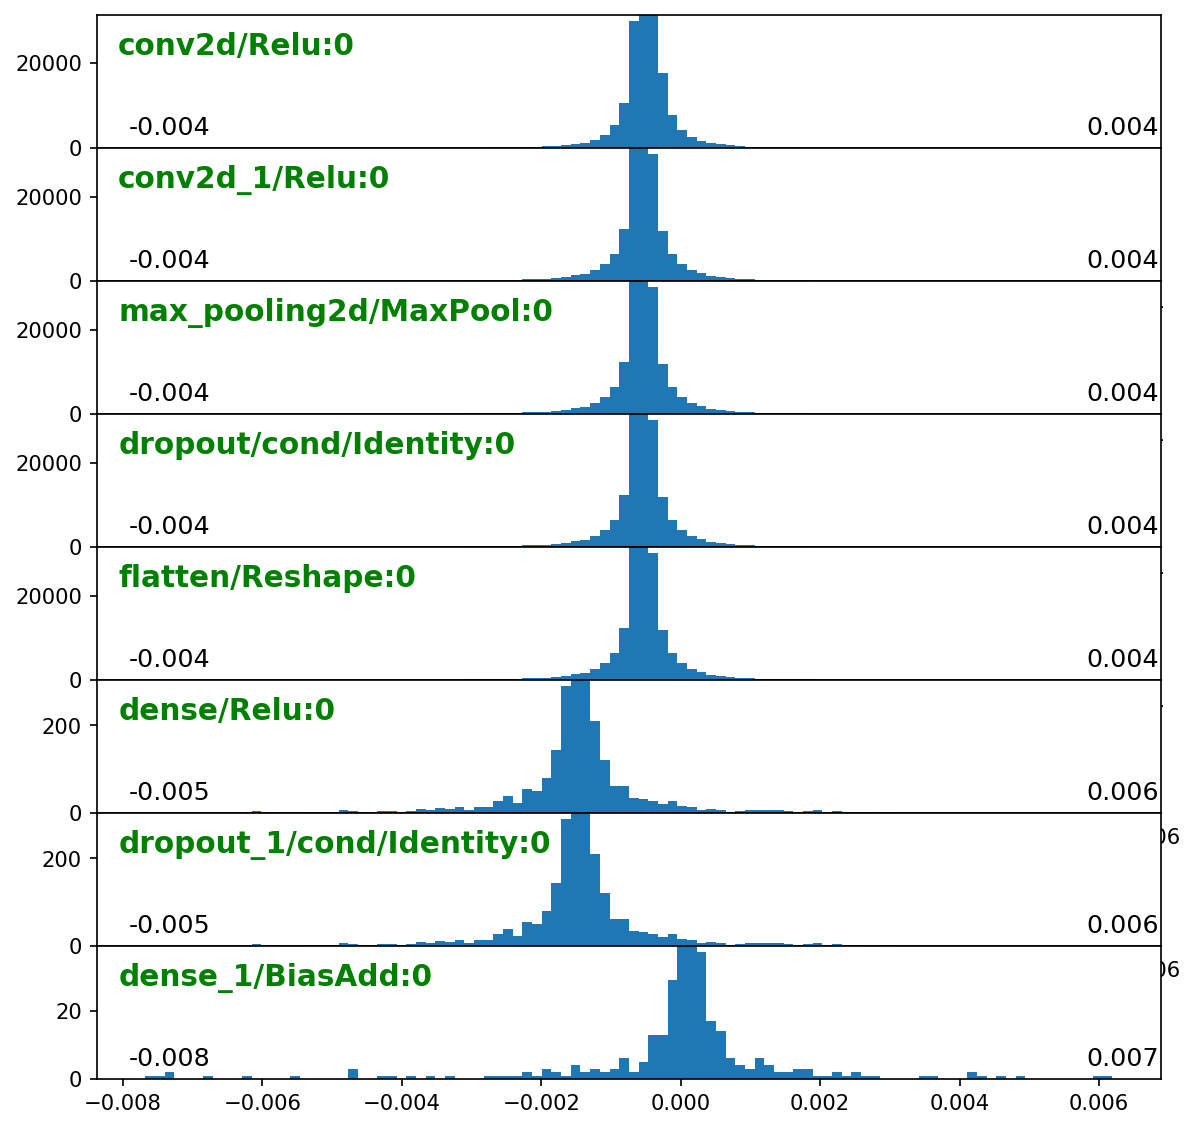

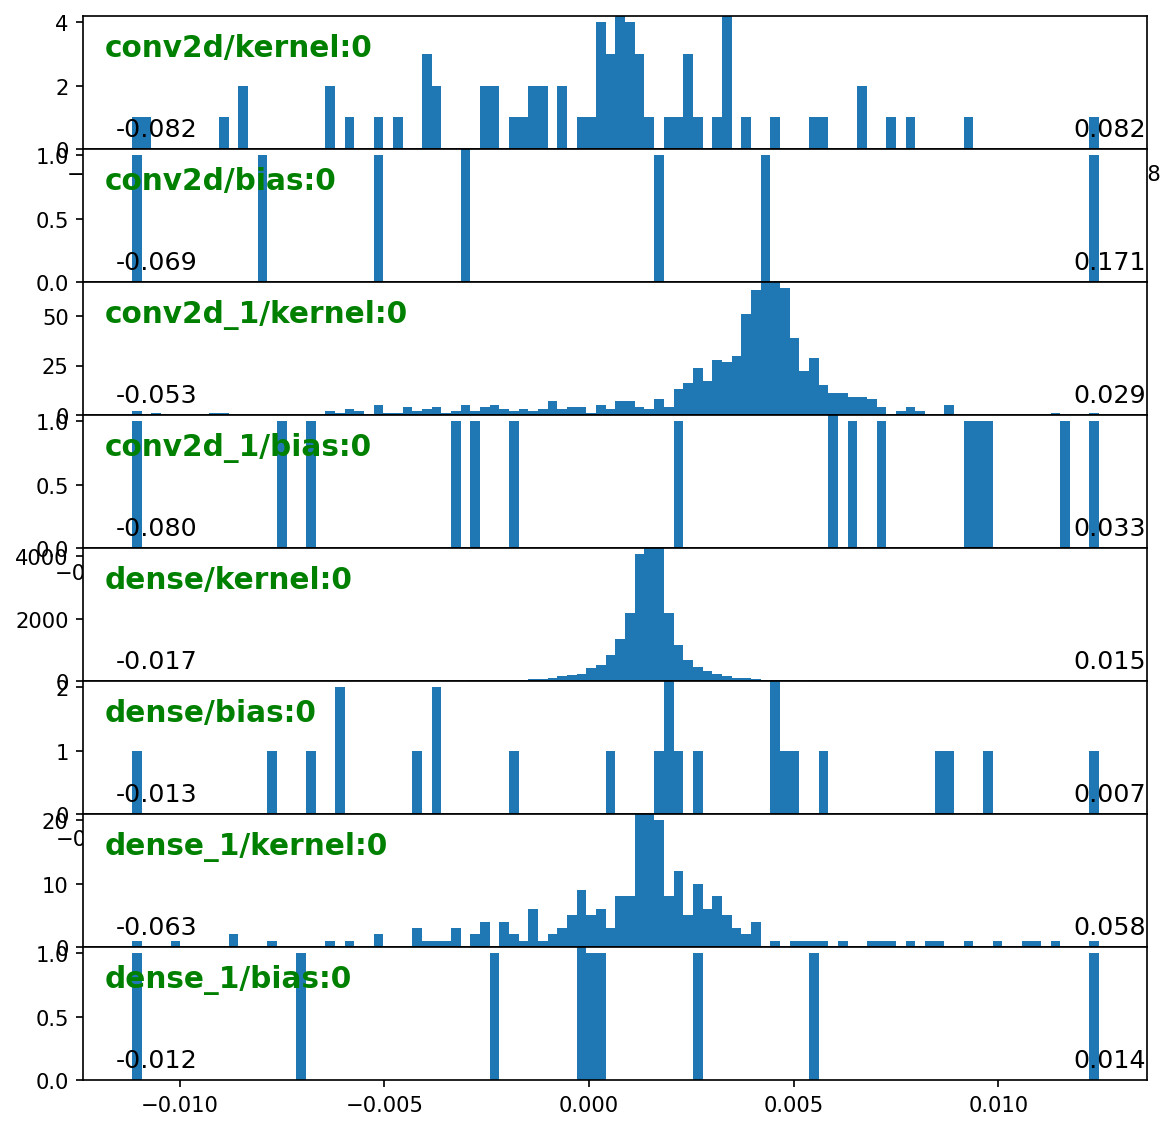

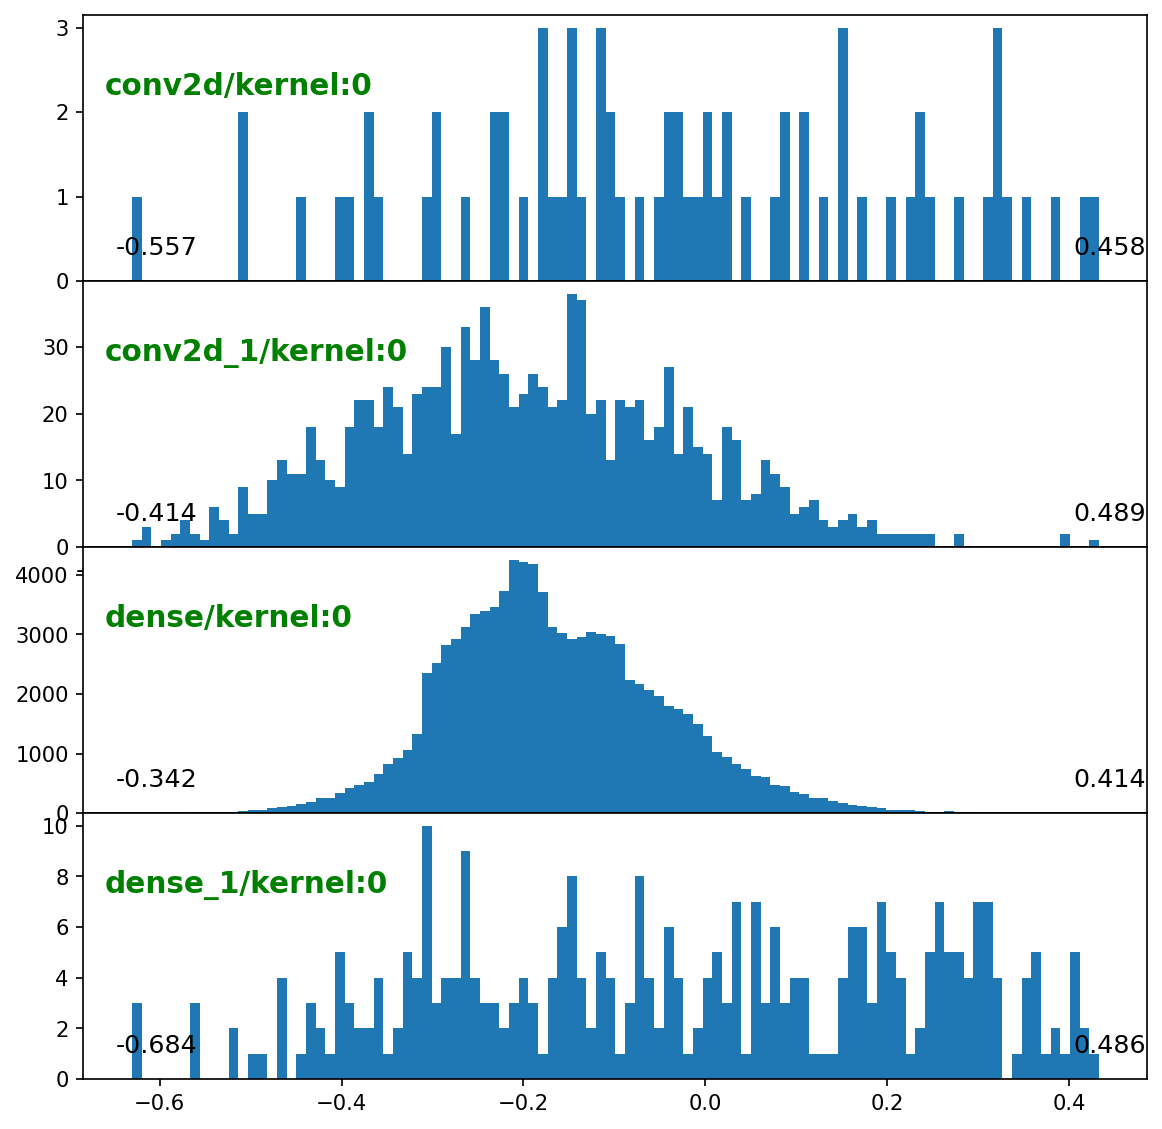

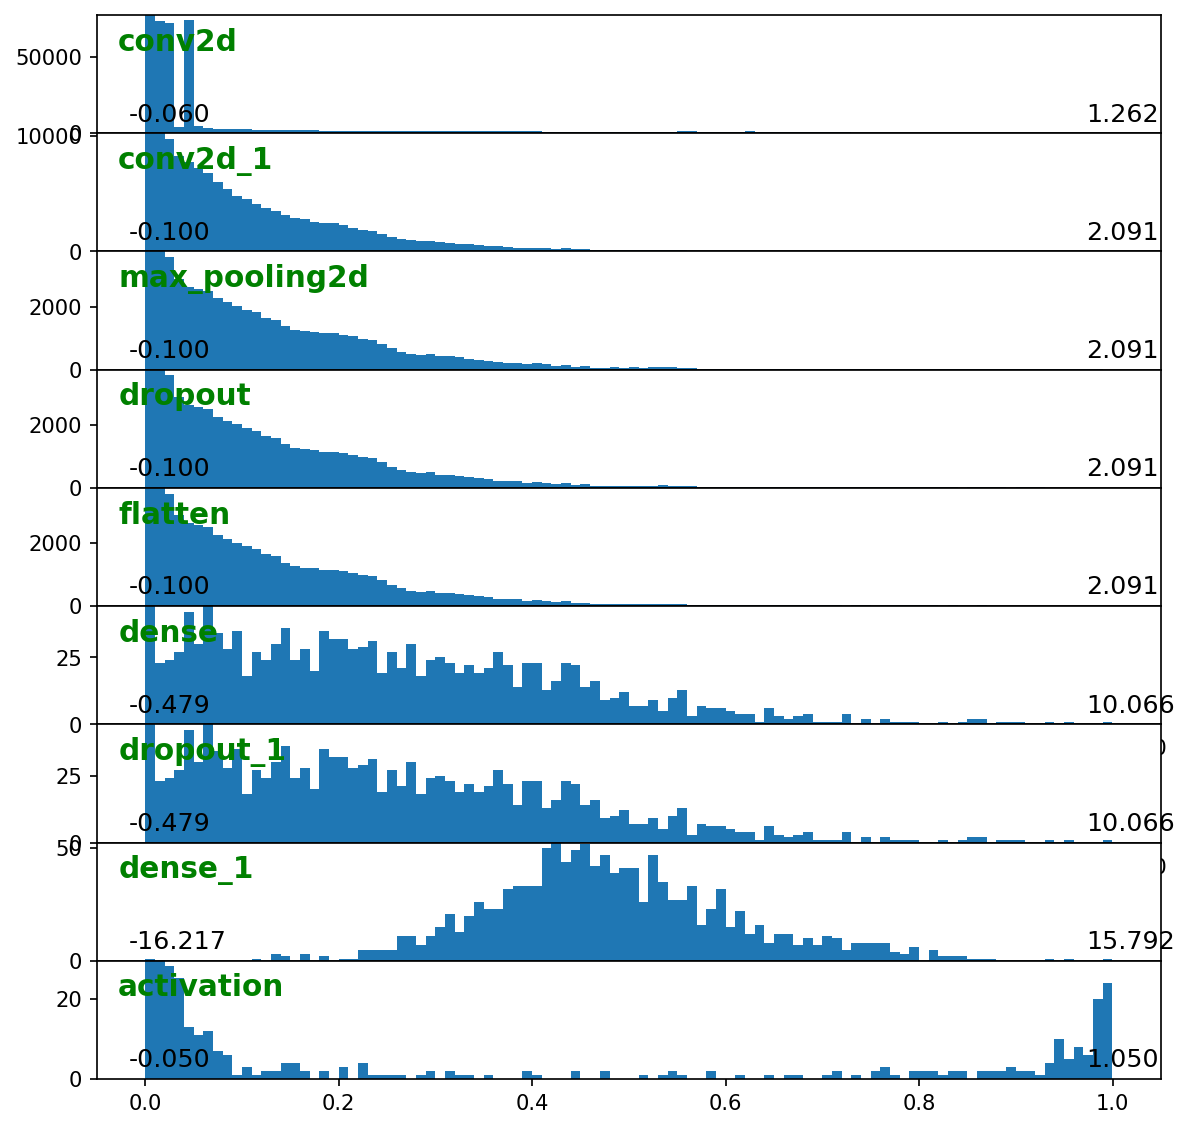


Data set_nums shuffled


_____________________
 EPOCH 2 -- COMPLETE 

RANDOM SEEDS RESET (random: 1, numpy: 1, tf-graph: 1, tf-global: 1)


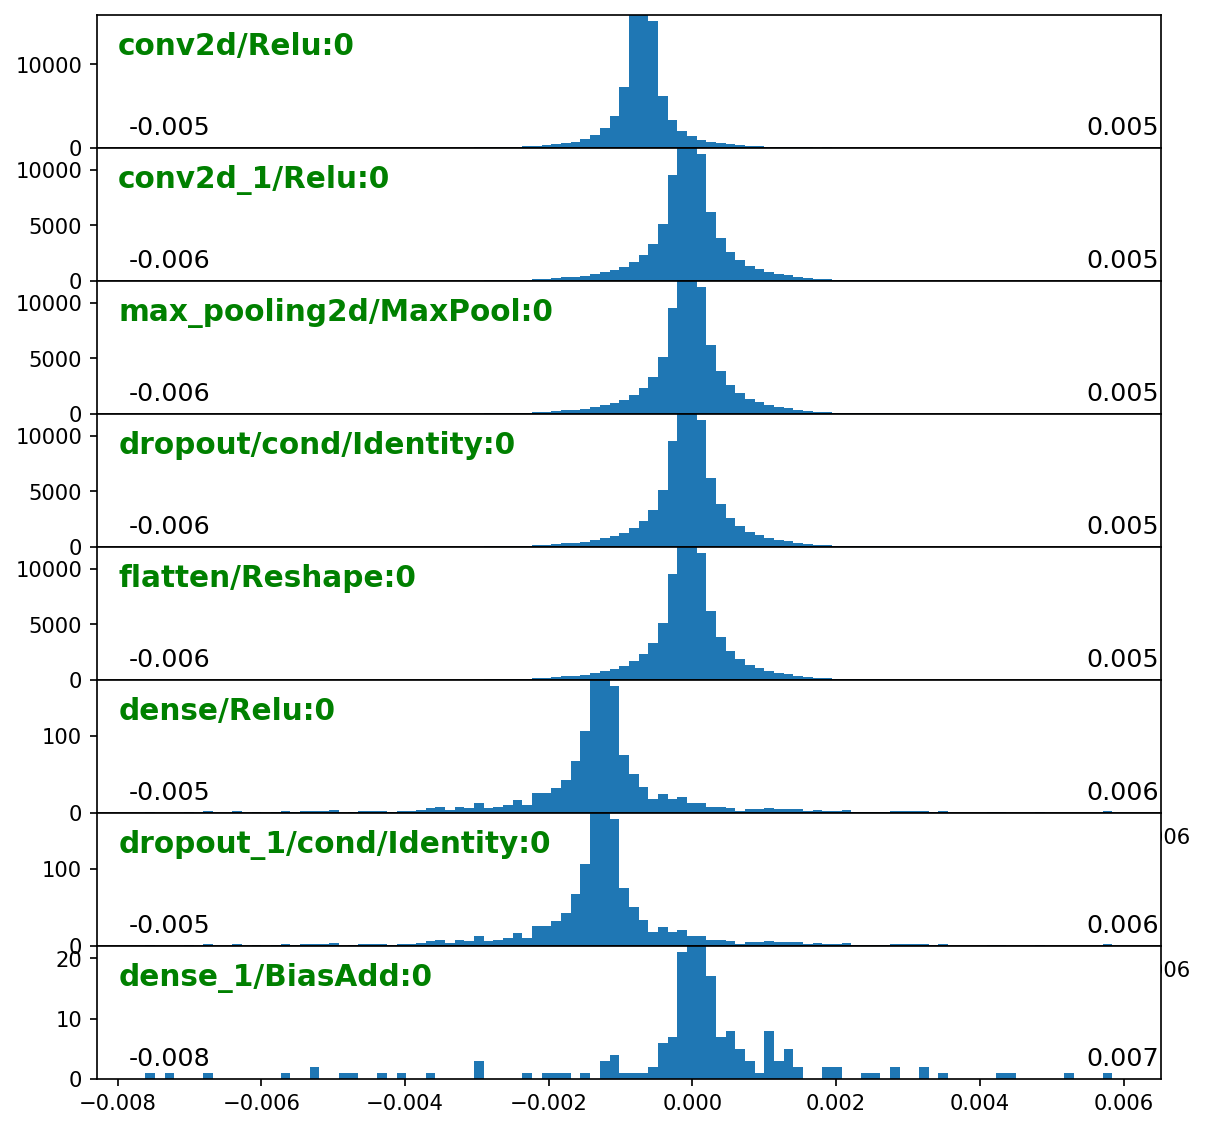

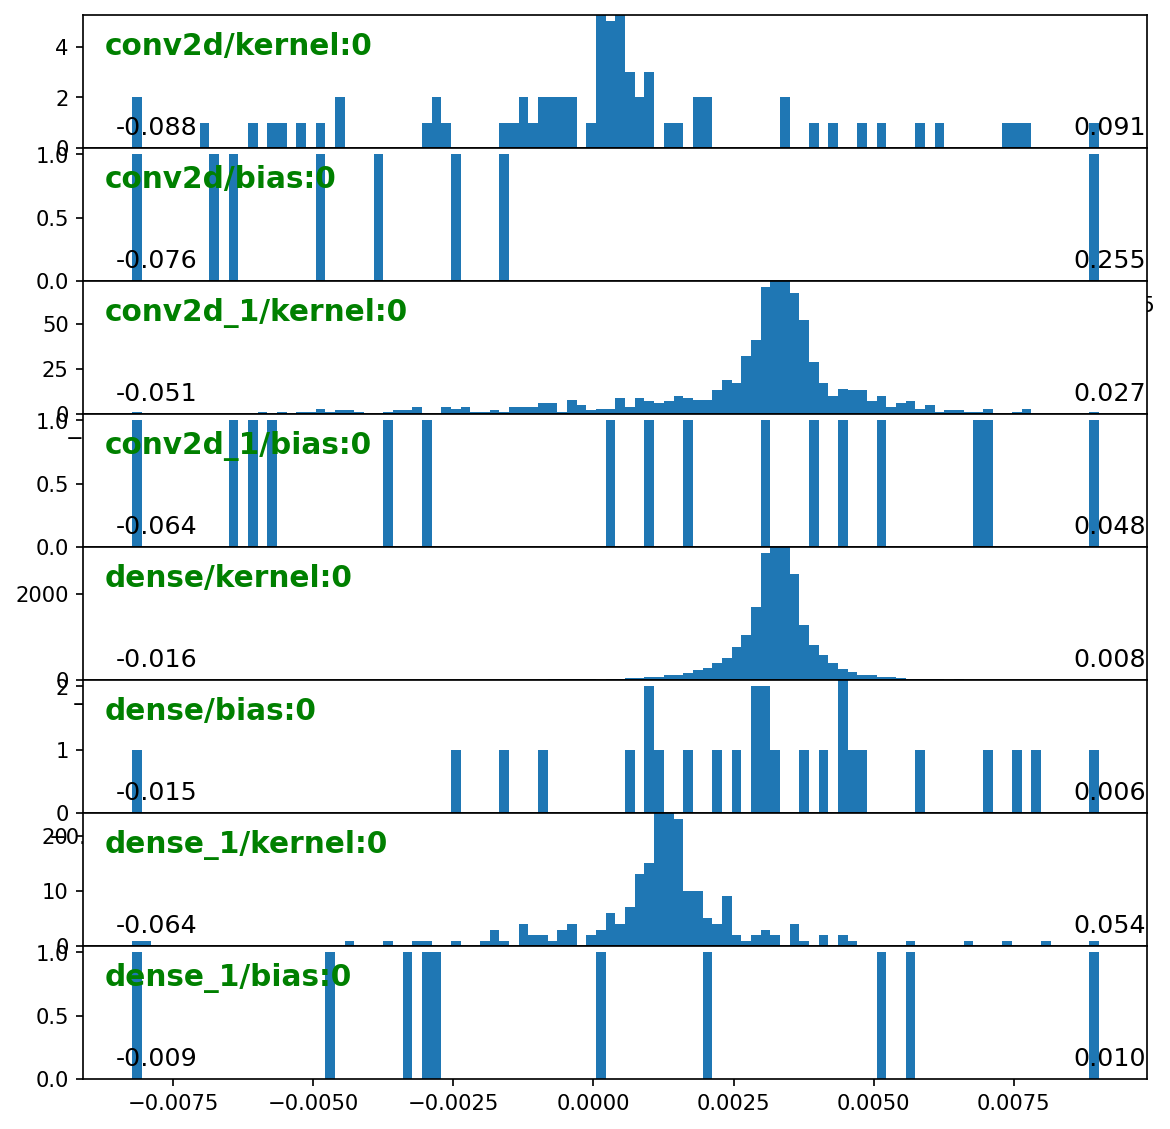



Validating...
TraingenLogger data saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logger\datalog_2.h5
TrainGenerator state saved
Model report generated and saved
Best model saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\models\M1__model-Adam__min.164
TraingenLogger data saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logger\datalog_2.h5
TrainGenerator state saved
Model report generated and saved


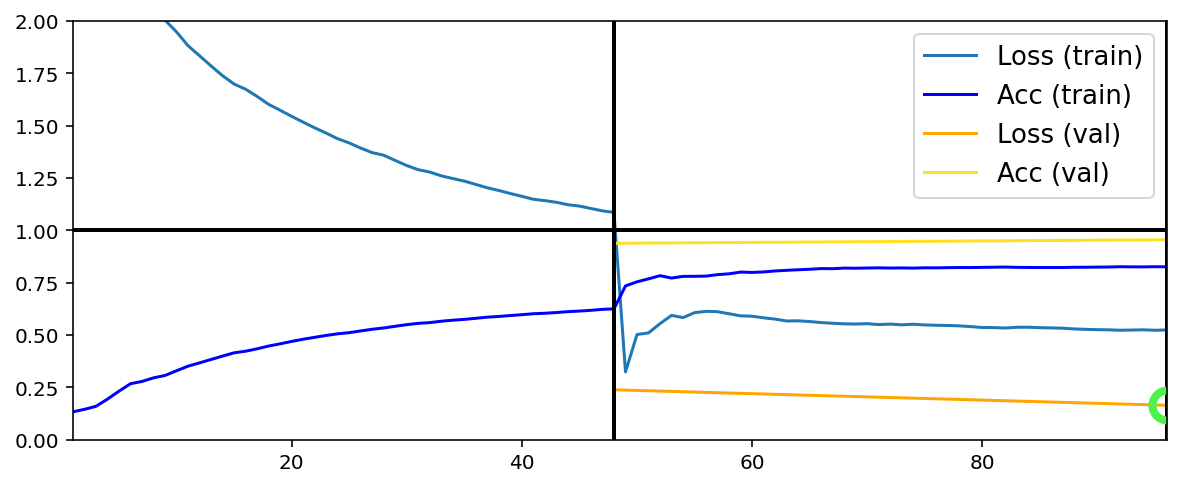

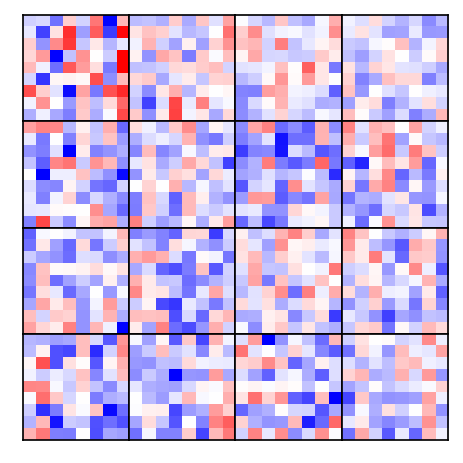

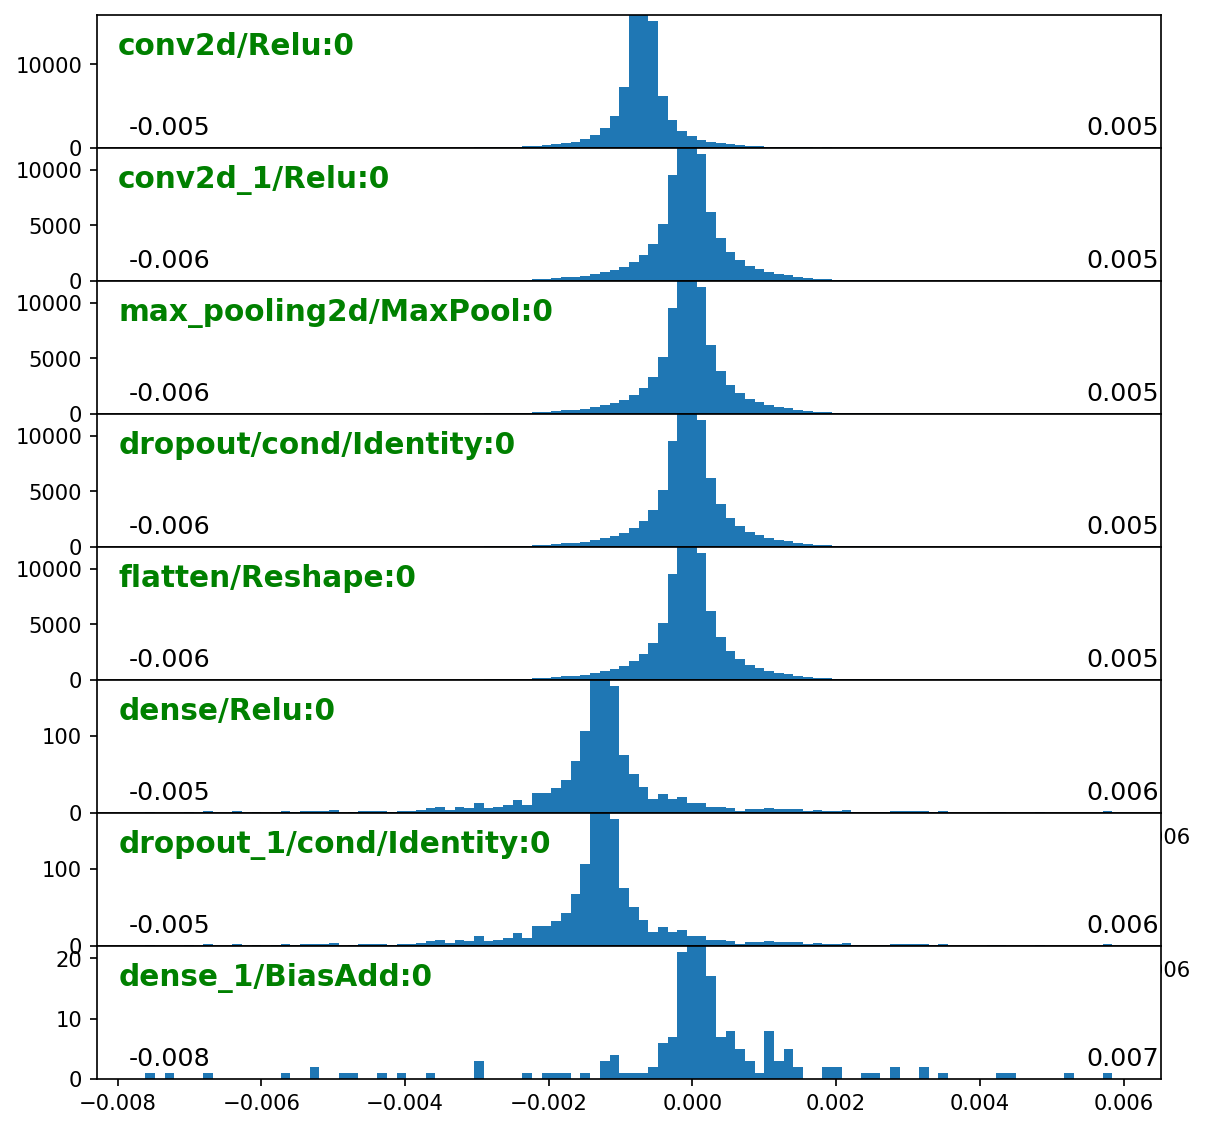

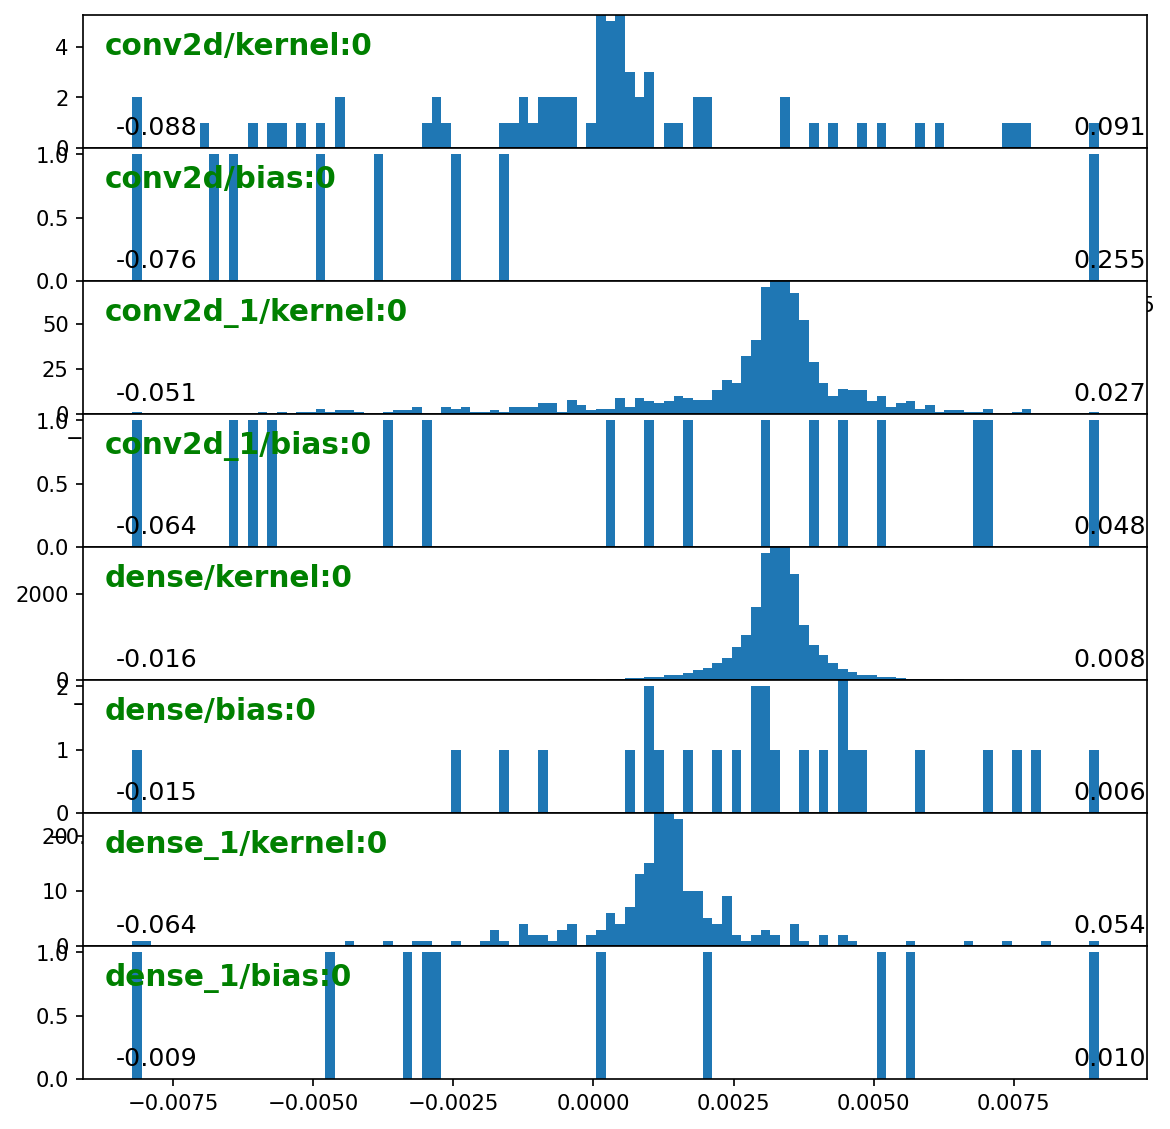

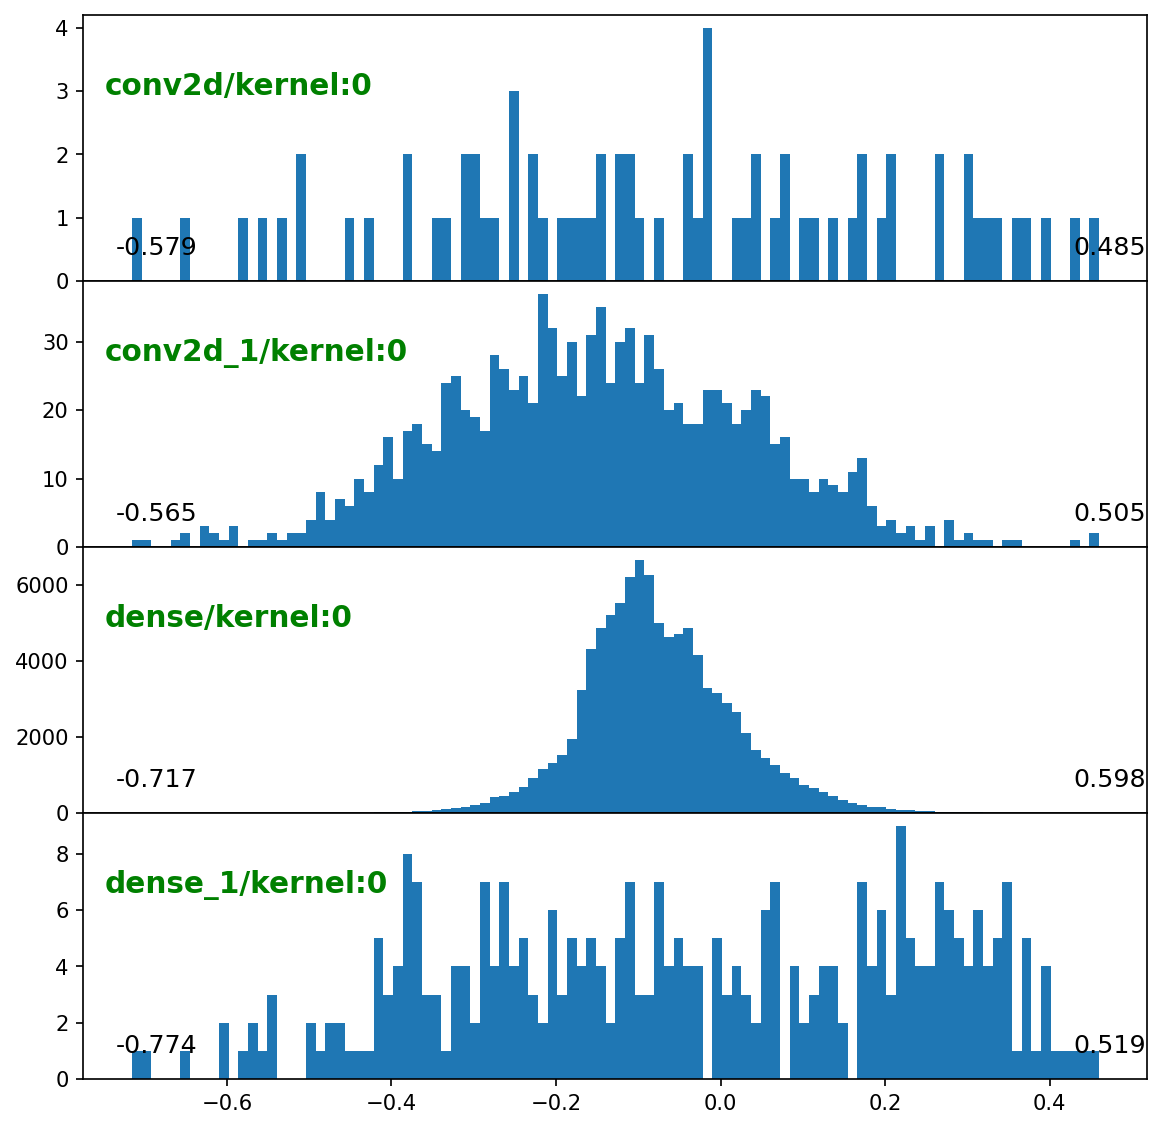

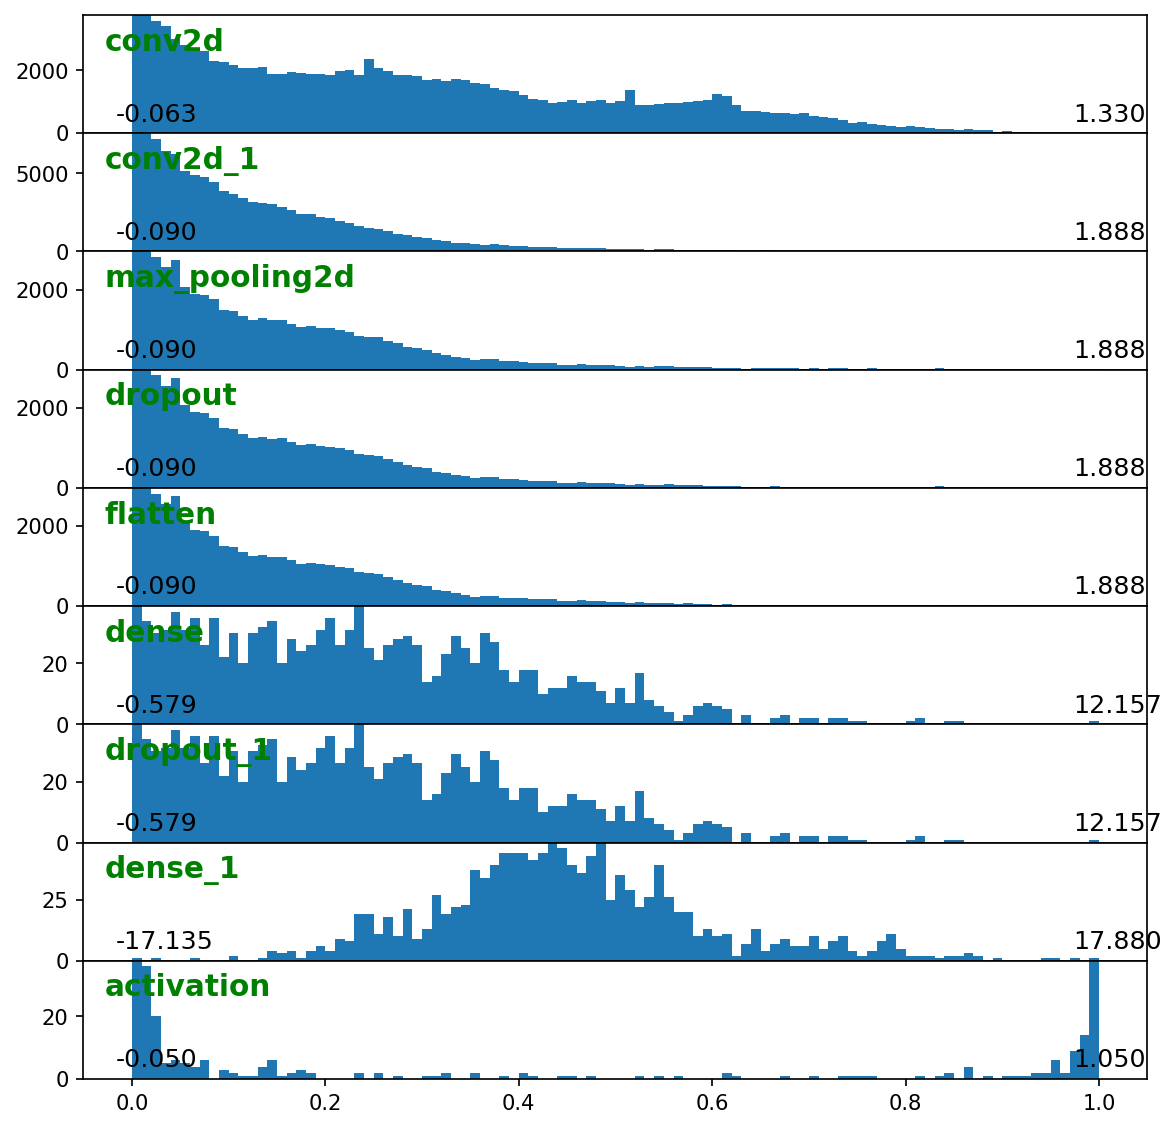


Data set_nums shuffled


_____________________
 EPOCH 3 -- COMPLETE 



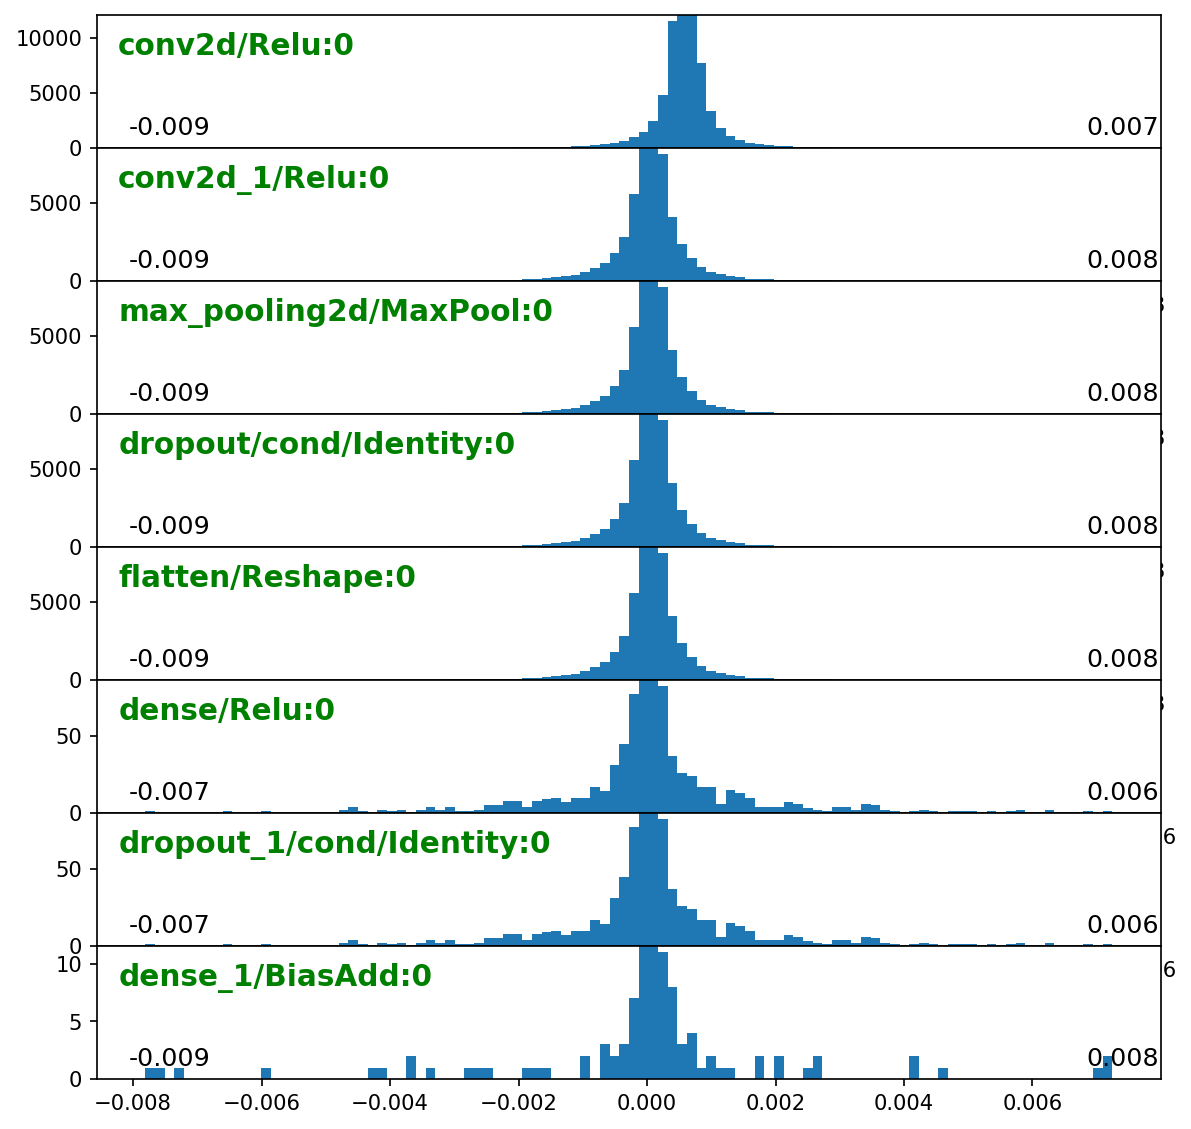

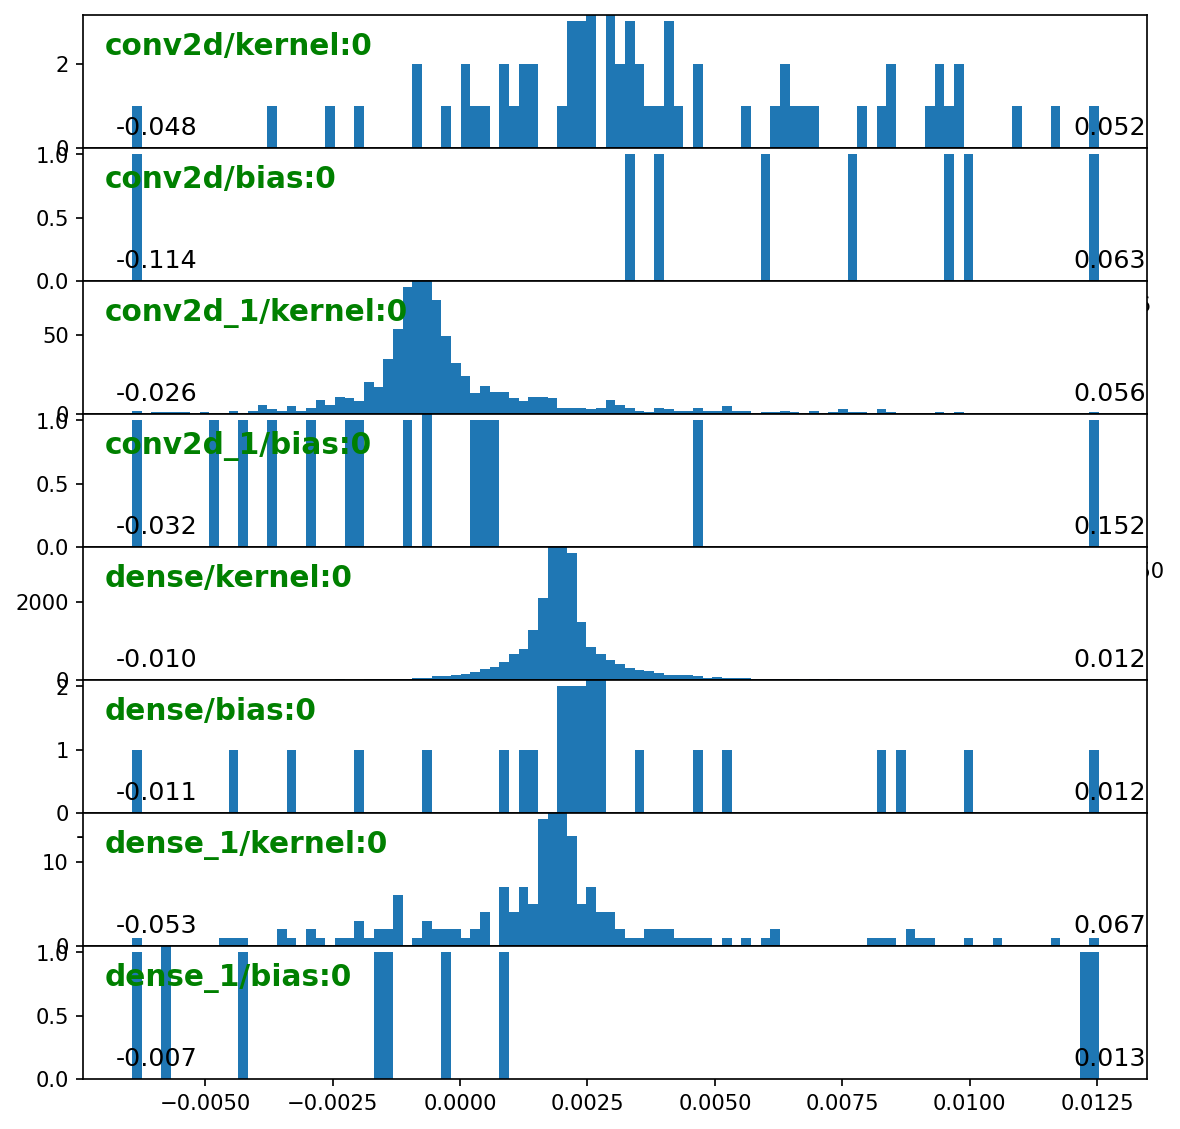



Validating...
TraingenLogger data saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logger\datalog_3.h5
TrainGenerator state saved
Model report generated and saved
Best model saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\models\M1__model-Adam__min.129
TraingenLogger data saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logger\datalog_3.h5
TrainGenerator state saved
Model report generated and saved


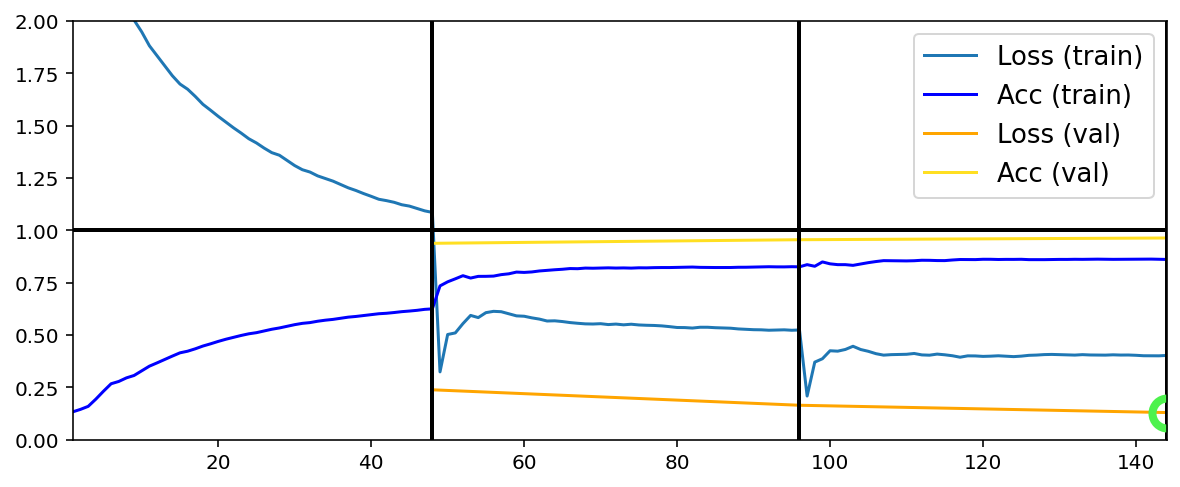

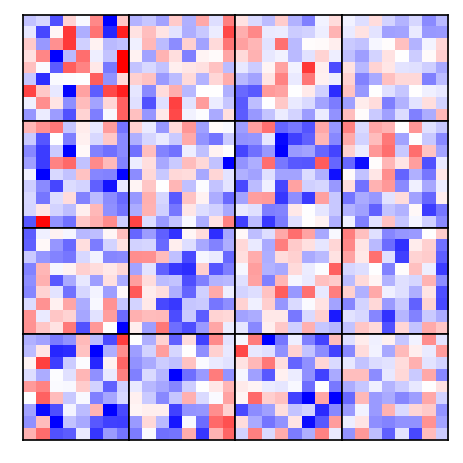

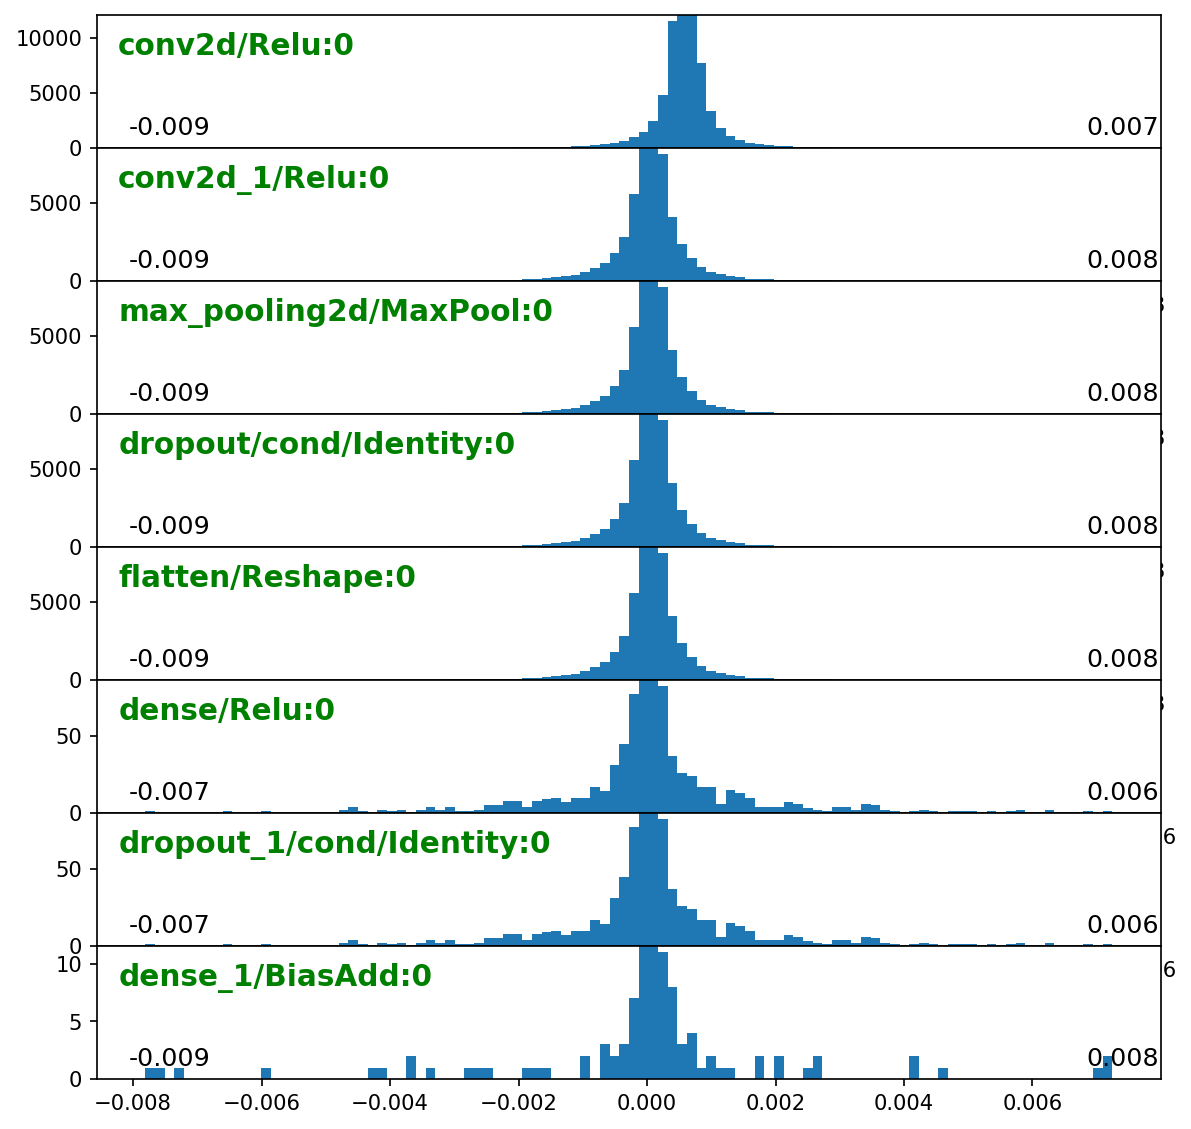

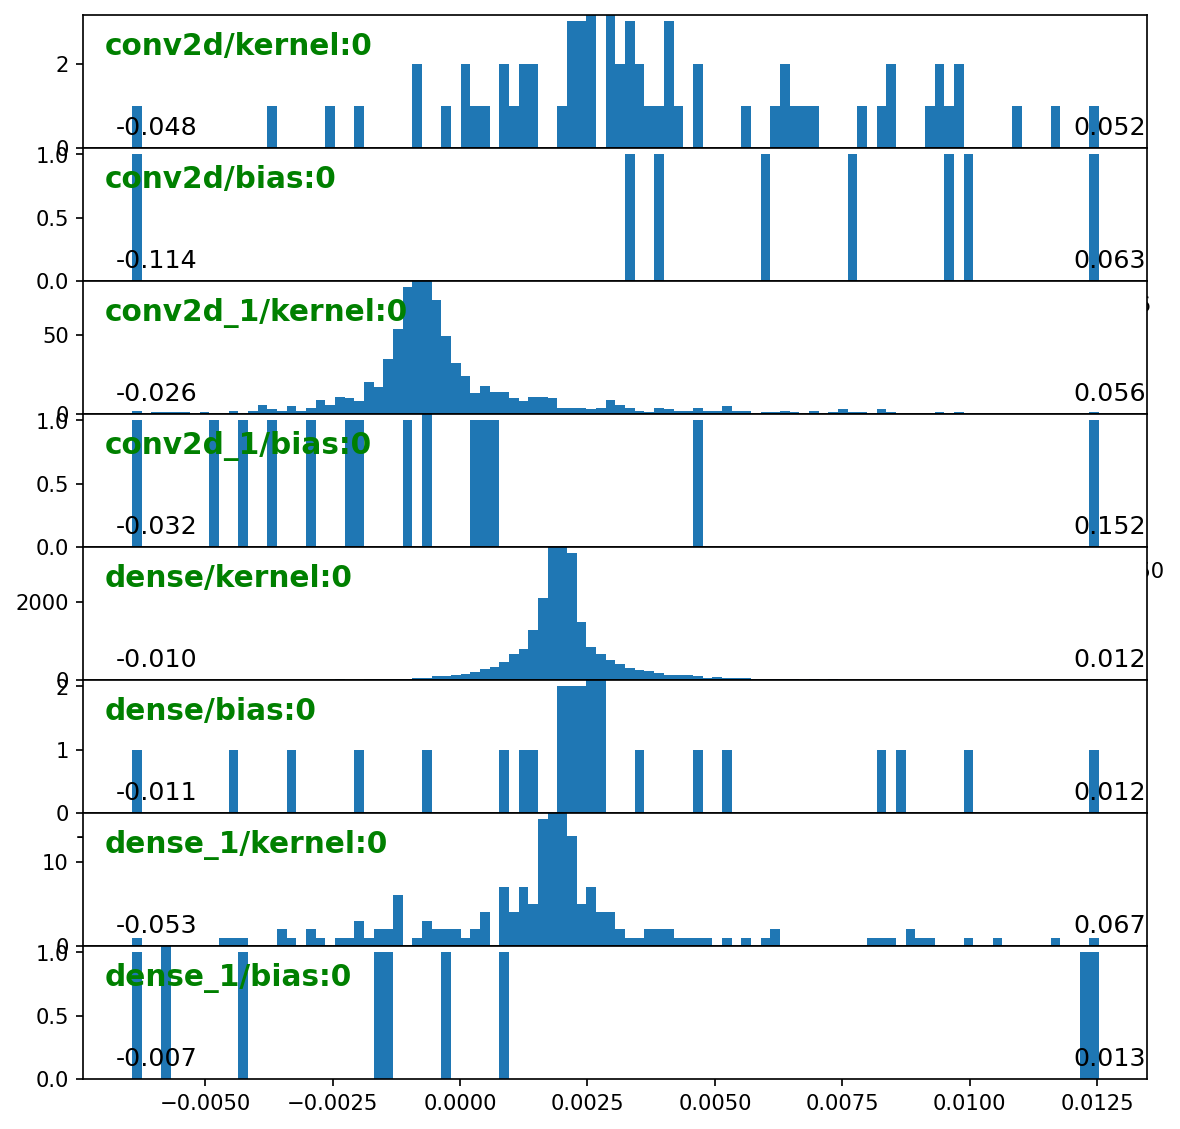

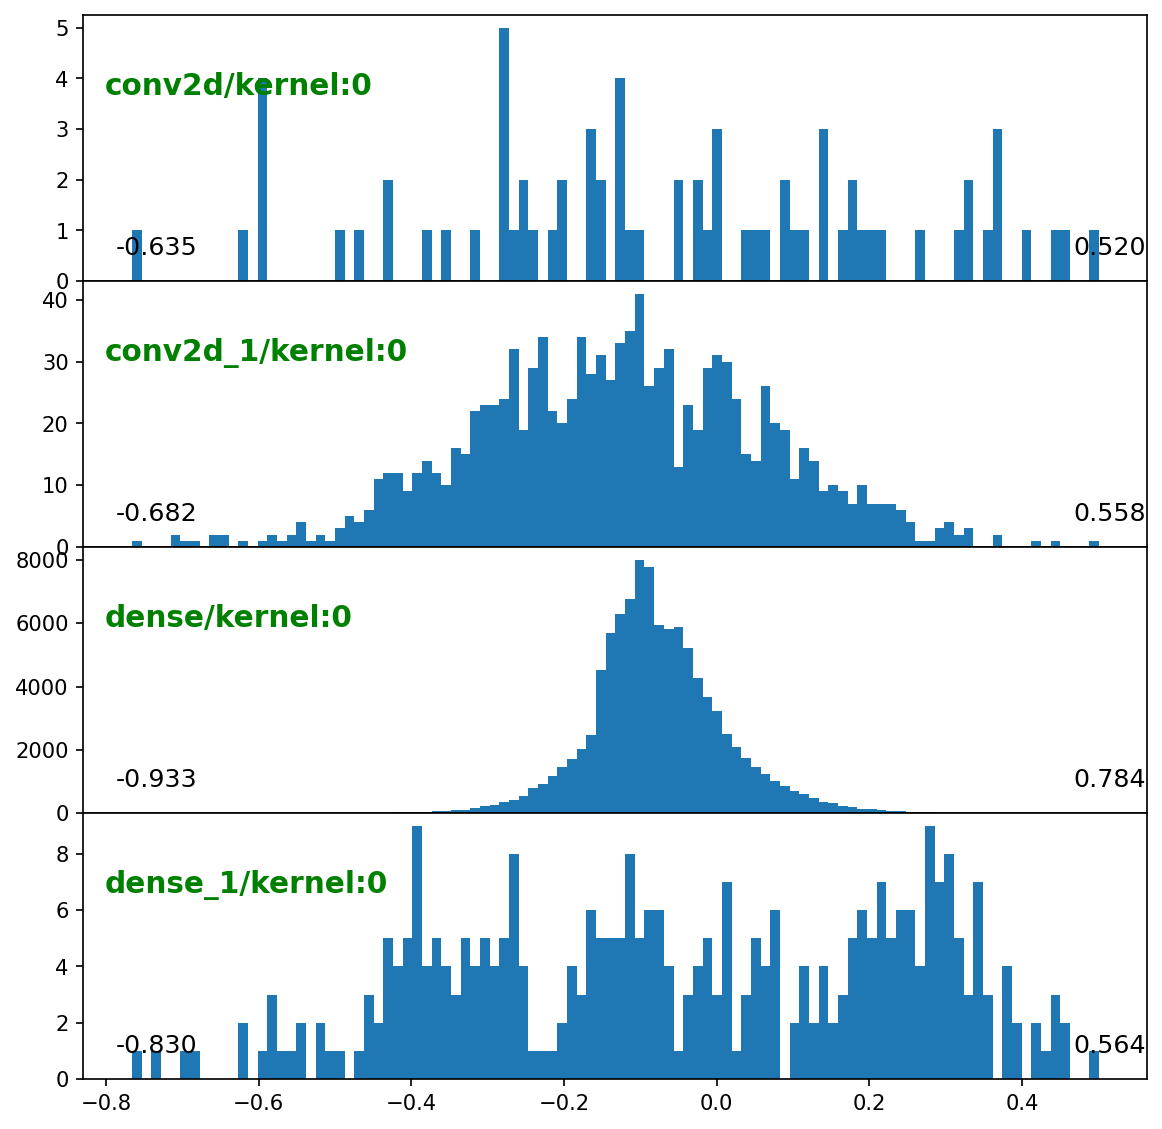

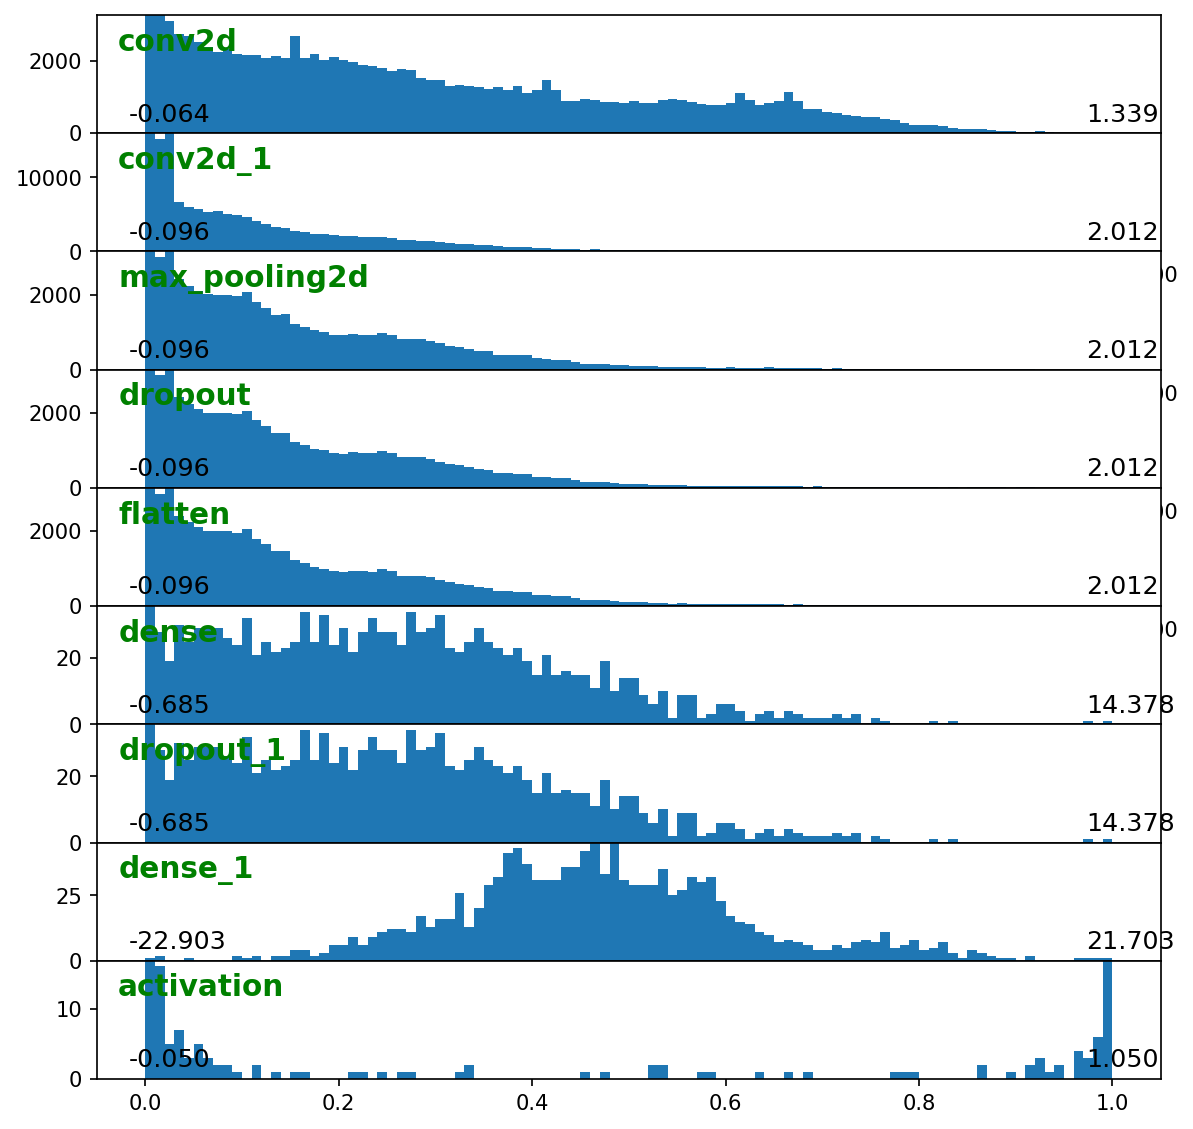


Data set_nums shuffled


_____________________
 EPOCH 4 -- COMPLETE 

RANDOM SEEDS RESET (random: 2, numpy: 2, tf-graph: 2, tf-global: 2)


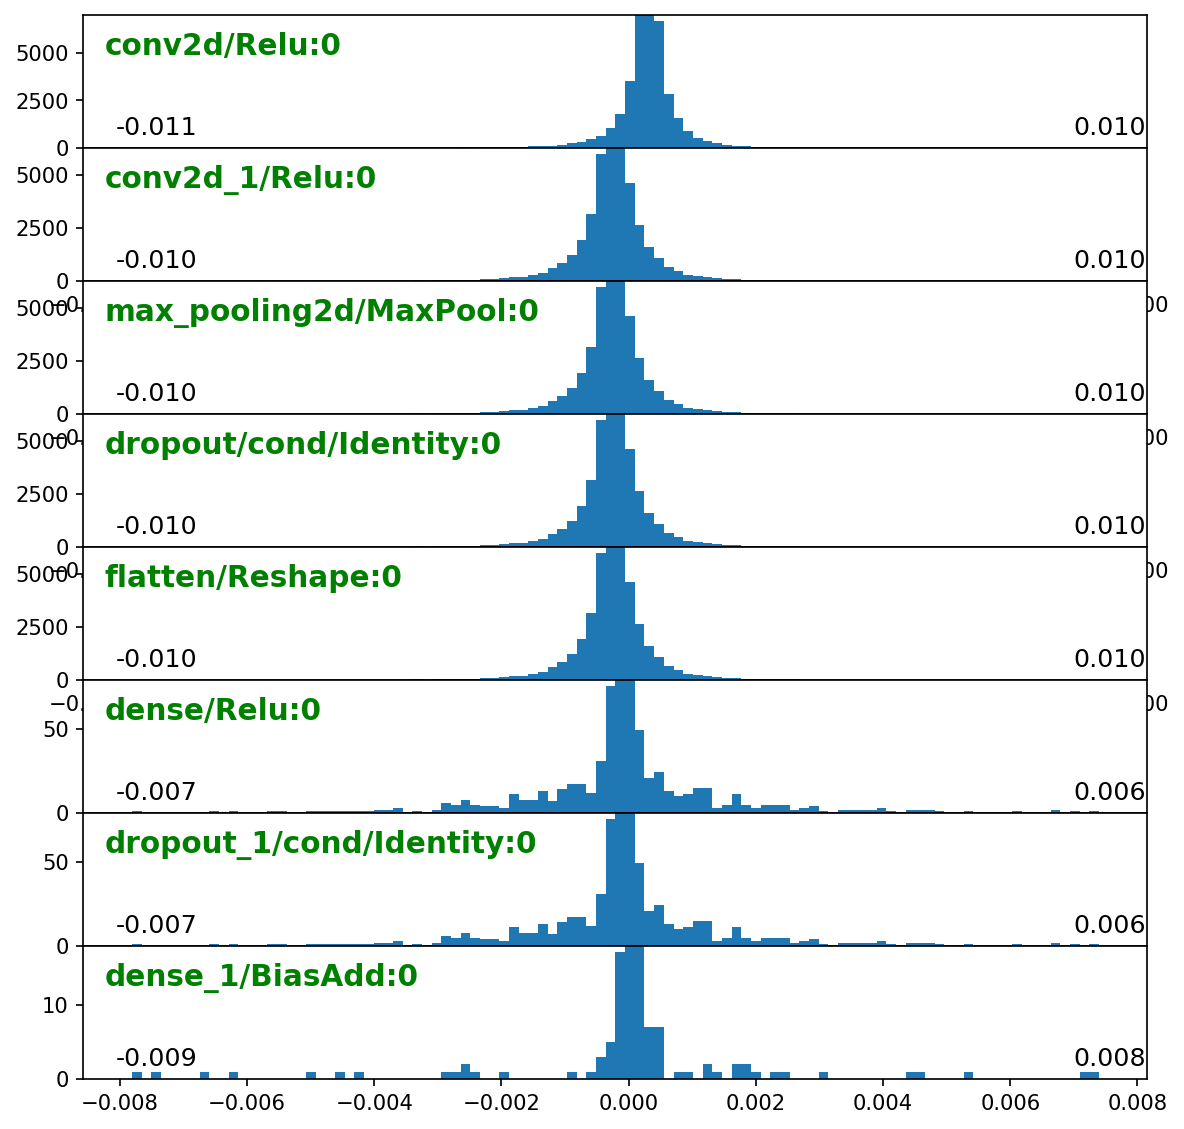

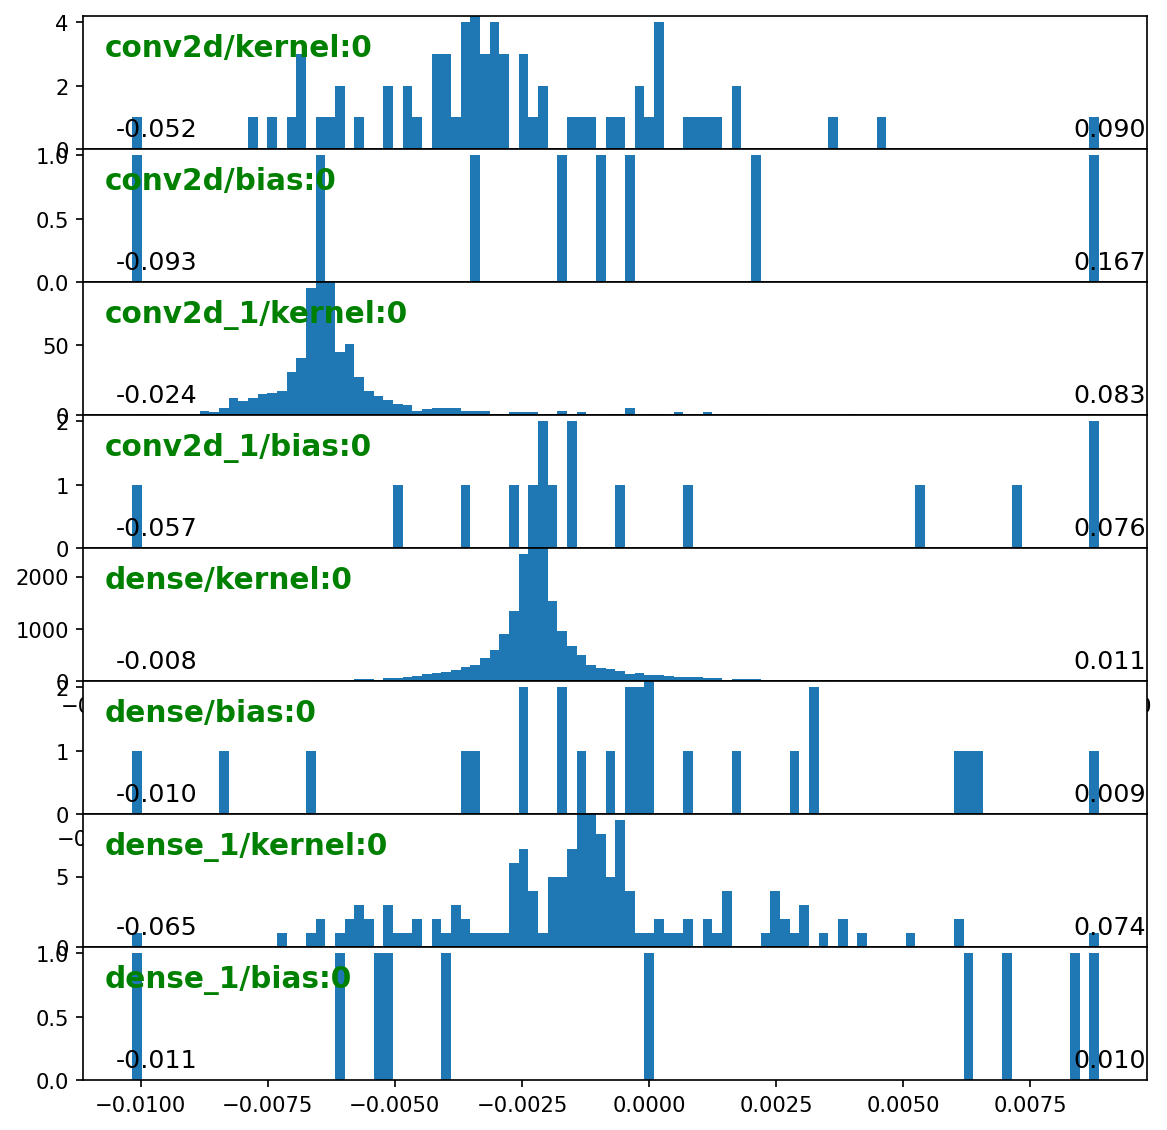



Validating...
TraingenLogger data saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logger\datalog_4.h5
TrainGenerator state saved
Model report generated and saved
Best model saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\models\M1__model-Adam__min.109
TraingenLogger data saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logger\datalog_4.h5
TrainGenerator state saved
Model report generated and saved


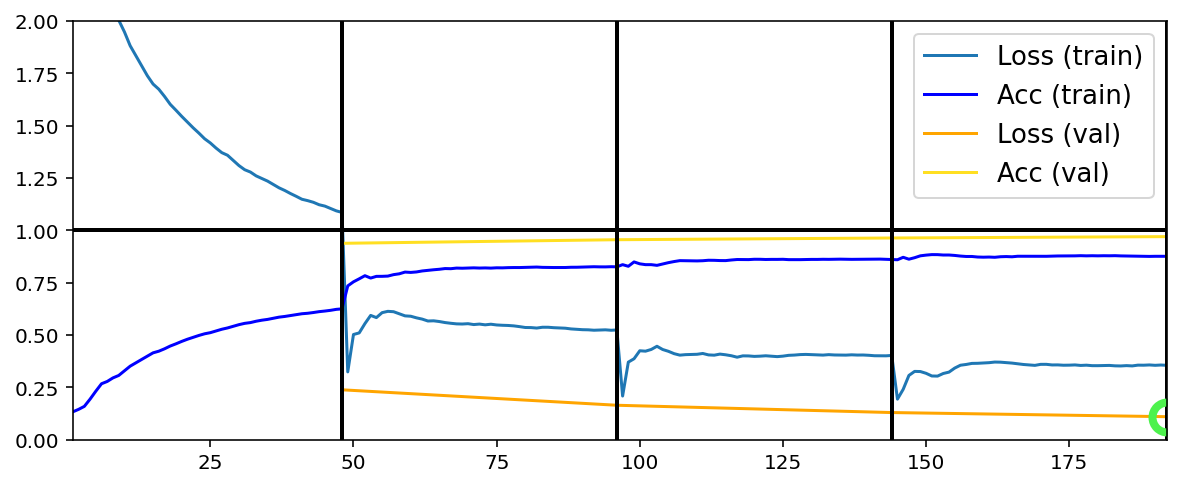

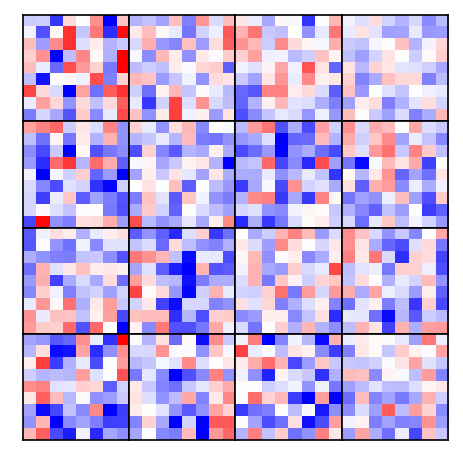

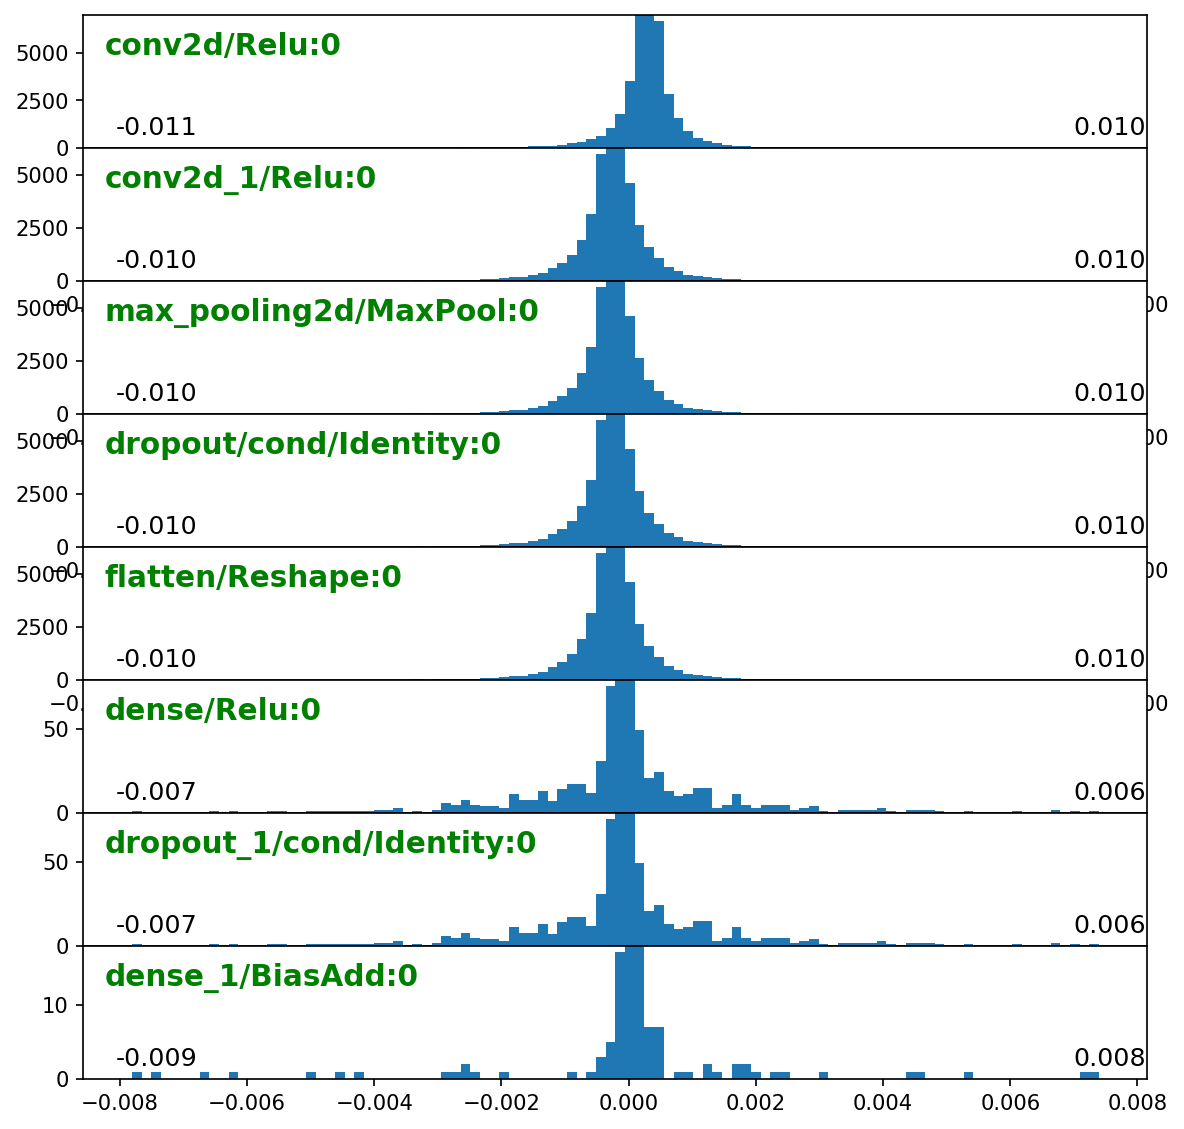

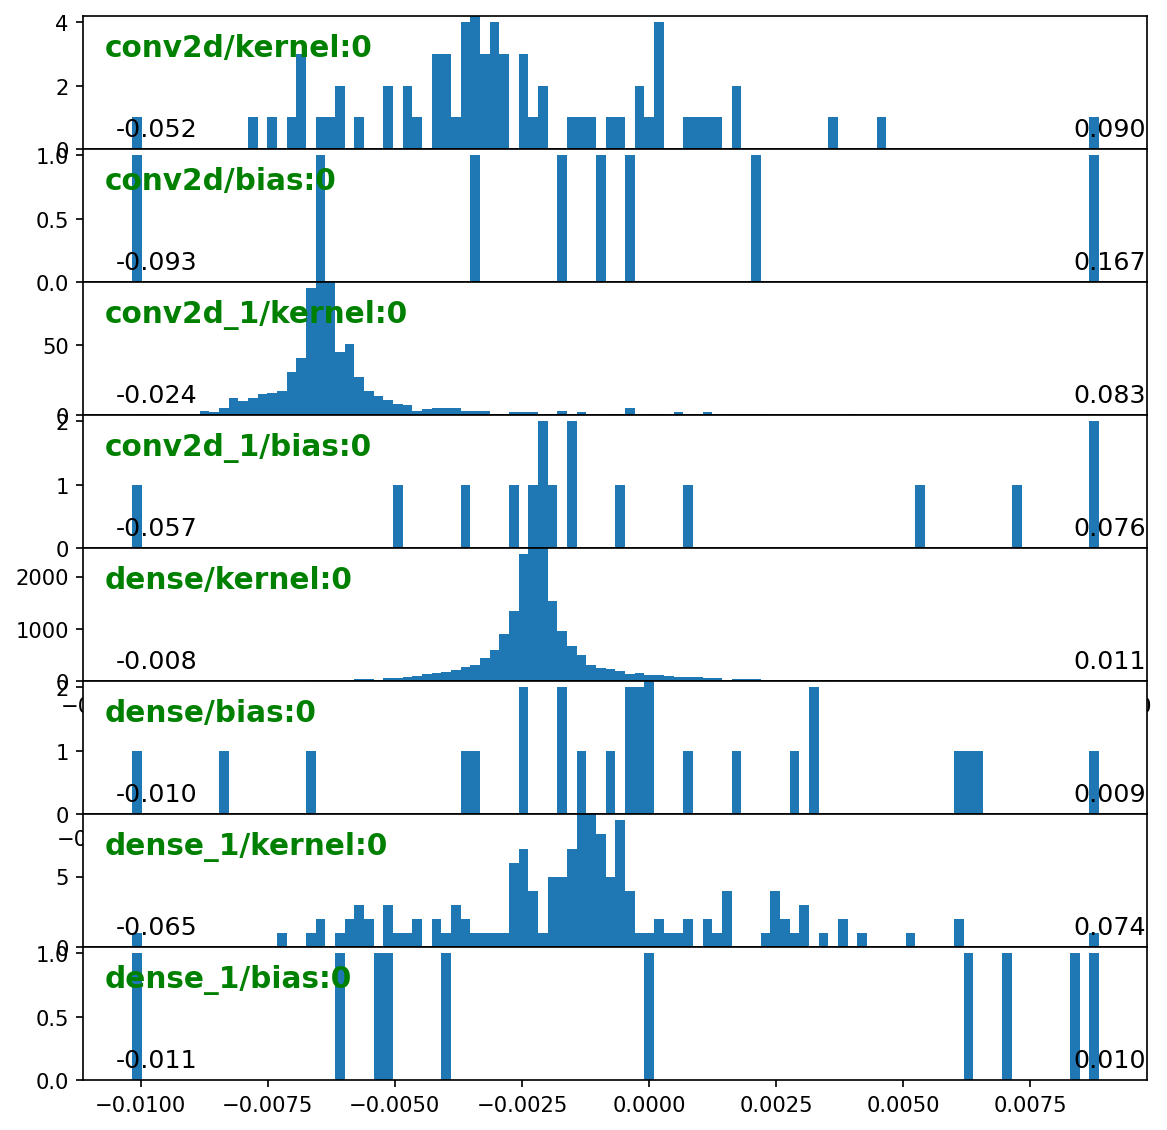

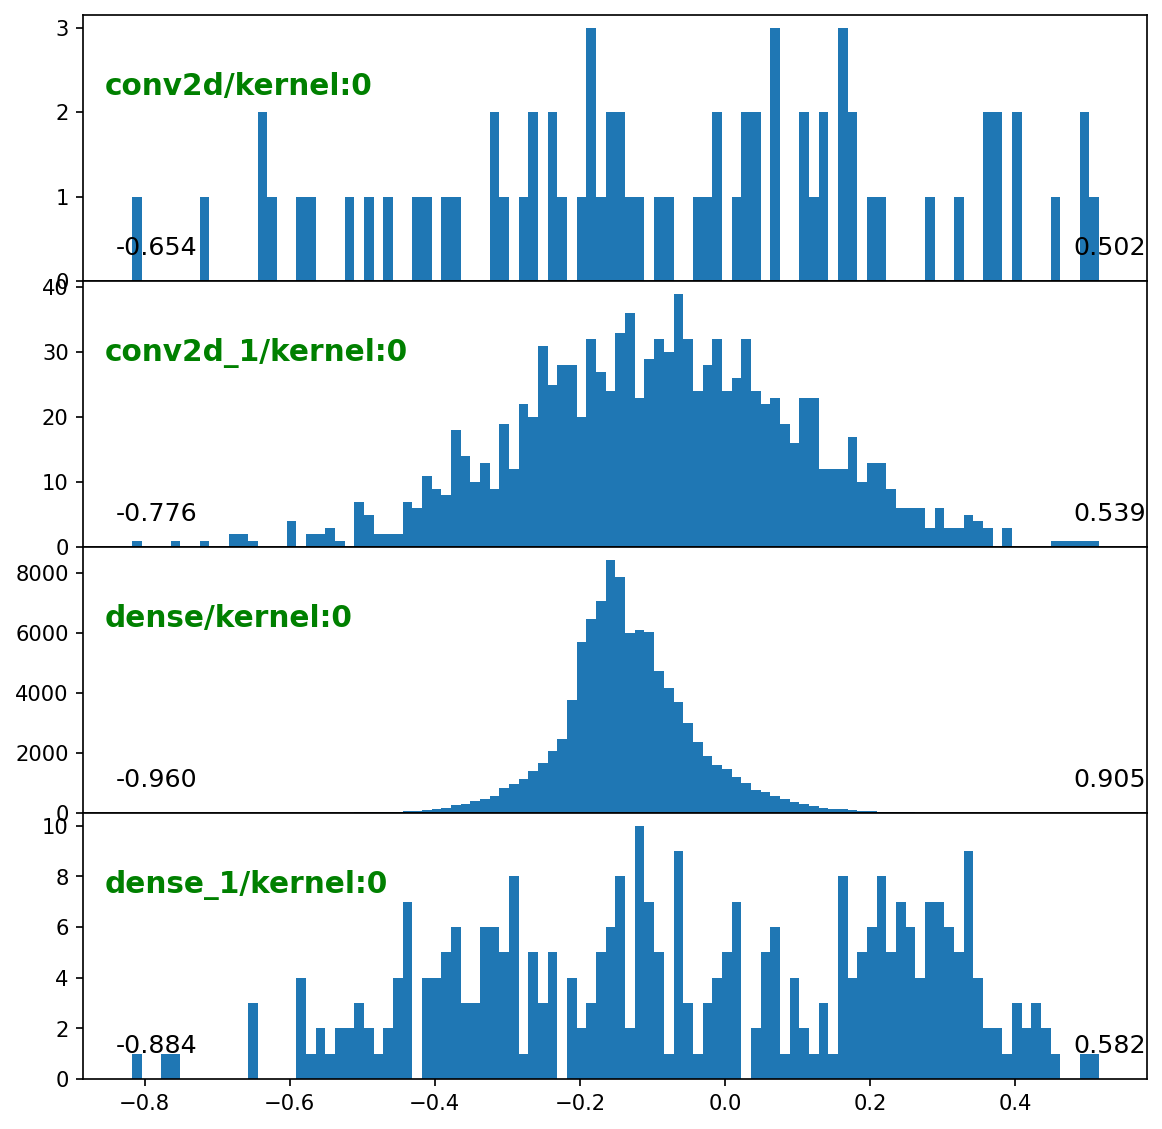

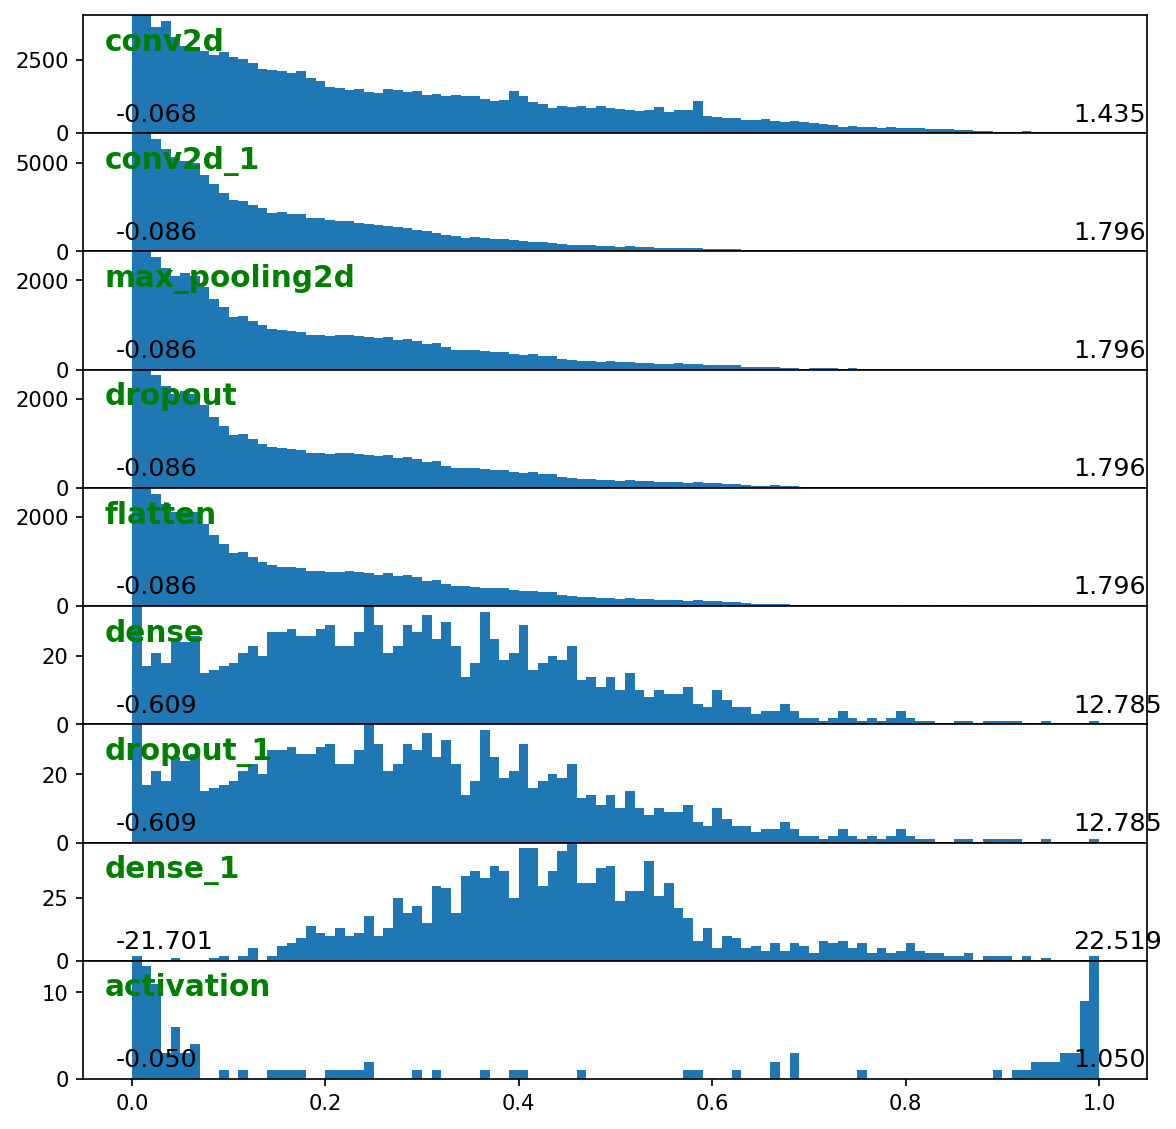

Training has concluded.


In [8]:
tg.train()

We can thus track the progression of layer gradients & activations epoch-to-epoch.

`examples/callbacks/mnist.py` shows an additional callback; notebook shortened.